In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean', 'diag', 'random', 'cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [22]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# enable 16 bit precision for jax                                                                                                                             
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, random

import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
from numpyro.distributions import Normal
import optax

# Import GSM                                                                                                                                                  
import sys
sys.path.append('../gsmvi//')
from gsm import GSM
from bbvi import ADVI, Scorenorm, Fishernorm
#####                                                                                                                                                         
from initializers import lbfgs_init

# sys.path.append('../utils/')
# from monitors import KLMonitor_Gauss as Monitor

import tensorflow_probability as tfp
SinhArcsinh = tfp.substrates.jax.distributions.SinhArcsinh
MultivariateNormal_tf = tfp.substrates.jax.distributions.MultivariateNormalFullCovariance


In [23]:
from gsmvi.monitors import KLMonitor as Monitor


# models

In [24]:

##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10, rank=4):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples




def setup_gauss_model_badcond(D, seed=123, noise=1e-2, mean=None):
    np.random.seed(seed)
    if mean is None:
        mean = np.random.random(D)
    L = np.random.normal(size = D**2).reshape(D, D)
    cov = np.matmul(L, L.T) + np.eye(D)*noise
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 5000)
    return mean, cov, lp, lp_g, ref_samples


D = 64
rank = 32
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))



# BAM, BAM_lr

In [25]:
# from bam import BAM
# from gsm import GSM
# from gsmvi.monitors import KLMonitor
# # from gsmvi.bam_lrproject import BAM_lrproject



In [26]:

# D = 64
# rank = 32
# model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)

# lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
# lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


In [27]:
# # alg = GSM(D, lp, lp_g)
# # alg = GSM(D, lp_vmap, lp_g_vmap)
# alg = BAM(D, lp_vmap, lp_g_vmap)
# key = jax.random.PRNGKey(2)

# monitor = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
# meanfit, covfit = alg.fit(key,  batch_size=16, niter=100, regf=lambda x: 100, monitor=monitor)

In [28]:
# from gsmvi.pbam import PBAM
# alg2 = PBAM(D, lp_vmap, lp_g_vmap)
# key = jax.random.PRNGKey(2)

# monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
# meanfit2, psi_fit, llambda_fit = alg2.fit(key, rank=8, batch_size=16, niter=200, regf=lambda x: 100, monitor=monitor2)
# covfit2 = np.diag(psi_fit) + llambda_fit@llambda_fit.T

In [29]:
# i = np.random.randint(D)
# print(i)
# plt.hist(np.random.multivariate_normal(meanfit, covfit, 10000)[..., i], bins=100, density=True, alpha=0.7, label='BAM');
# plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., i], bins=100, density=True, alpha=0.7, label='BAM_lr');
# plt.hist(ref_samples[..., i], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');
# plt.legend()

# Code development below

# code copied
Code taken from https://github.com/je-suis-tm/machine-learning/blob/master/factor%20analysis.ipynb

In [30]:
#get latent variables z
#andrew ng didnt teach us how to get the latent
#we have to borrow ideas from sklearn even though we dont know why
#alternatively
#x=miu+lambda_@z+epsilon
#z=inverse(lambda_)@(x-miu-epsilon)
#but this is incorrect
#as we dont know epsilon
#we can only assume its zero
#z=np.linalg.pinv(lambda_)@(data-miu).T
@jit
def get_latent(data,miu,lambda_,psi):
    
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    weighted_psi = lambda_.T@psi_inv
    cov_z = jnp.linalg.inv(jnp.identity(lambda_.shape[1])+weighted_psi@lambda_)
    z= (data - miu)@(weighted_psi).T@cov_z
    
    return z


#pdf of multivariate gaussian
#equivalent to scipy.stats.multivariate_normal(miu,sigma).pdf(data)
def multivariate_gaussian(data,miu,sigma):
    
    numerator=np.exp(-0.5*(data-miu)@np.linalg.inv(sigma)@(data-miu).T)
    denominator=(2*np.pi)**(data.shape[1]/2)*np.linalg.det(sigma)**0.5

    return np.diagonal(numerator/denominator)


#unlike gmm, only p(x|z) depends on the params
#thus the computation can be simplified
#although we have one more step of computing z
# def get_lower_bound(data,miu,lambda_,psi):
    
#     #transform x
#     z=get_latent(data,miu,lambda_,psi)

#     #logarithm multivariate gaussian
#     logpdf=np.log(multivariate_gaussian(data-(lambda_@z.T).T,miu,psi))    
#     lower_bound=sum(logpdf)
    
#     return lower_bound


@jit
def get_lower_bound(data, mu, llambda, psi):
    
    z = get_latent(data, mu, llambda, psi)    
    loc = (llambda@z.T).T
    scale = jnp.diag(psi)**0.5
    logpdf = Normal(loc, scale).log_prob(data)
    lower_bound = logpdf.sum()
    
    return lower_bound
    

In [31]:
# #e step
# #use lambda_ and psi to update conditional miu and sigma
# def e_step(data,miu,lambda_,psi):
    
#     #denote beta
#     beta=lambda_.T@np.linalg.inv(lambda_@lambda_.T+psi)

#     #compute conditional params
#     miu_z_given_x=beta@(data-miu).T
#     sigma_z_given_x=np.identity(lambda_.shape[1])-beta@lambda_
    
#     return miu_z_given_x,sigma_z_given_x

# #m step
# #use conditional miu and sigma to update lambda_,psi
# def m_step(data,miu,miu_z_given_x,sigma_z_given_x):

#     #equation 8 in stanford material
#     lambda_=(data-miu).T@miu_z_given_x.T@np.linalg.inv(miu_z_given_x@miu_z_given_x.T+sigma_z_given_x)

#     #last equation
#     phi=(data.T@data-2*data.T@miu_z_given_x.T@lambda_.T+ \
#          lambda_@(miu_z_given_x@miu_z_given_x.T+sigma_z_given_x)@lambda_.T)/data.shape[0]
    
#     #take diagonal
#     psi=np.diag(np.diag(phi))
    
#     return lambda_,psi




In [32]:
# #using mle for training
# def training(data,num_of_latents,
#              tolerance=0.001,num_of_itr=50,diagnosis=False):
        
#     #get dimensions
#     num_of_features=data.shape[1]
    
#     #initialize
#     lower_bound_old=None
#     lower_bound=None
#     counter=0
    
#     #miu is the unconditional mean
#     miu=data.mean(axis=0)    
    
#     #lambda_ is the coefficient of the latent variables
#     #use principal components to initialize
#     #this approach improves the performance (Barber 2012)
#     _,eigvecs=np.linalg.eig((data-miu).T@(data-miu)/data.shape[0])
#     lambda_=eigvecs[:,:num_of_latents]

#     #psi is the covariance matrix of noise, a diagonal matrix
#     #use the diagonal of covariance matrix to initialize
#     psi=np.diag(np.diag((data-miu).T@(data-miu)/data.shape[0]))  

#     #cap the maximum number of iterations
#     while counter<num_of_itr:
        
#         #e step
#         miu_z_given_x,sigma_z_given_x=e_step(data,miu,lambda_,psi)
            
#         #m step
#         lambda_,psi=m_step(data,miu,
#                            miu_z_given_x,
#                            sigma_z_given_x)
            
#         #use lower bound to determine if converged
#         lower_bound_old=lower_bound
#         lower_bound=get_lower_bound(data,miu,lambda_,psi)
            
#         if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
#             if diagnosis:
#                 print(f'{counter} iterations to reach convergence\n')
#             return miu_z_given_x,sigma_z_given_x,lambda_,psi
            
#         counter+=1
    
#     if diagnosis:
#         print(f'{counter} iterations to reach convergence\n')
        
#     return miu_z_given_x,sigma_z_given_x,lambda_,psi

# num_of_latents=2
# #load data
# iris=sklearn.datasets.load_iris()
# miu_z_given_x,sigma_z_given_x,lambda_,psi=training(iris.data,
#                                                    num_of_latents,
#                                                    diagnosis=True)
# clf=skl_fa(iris.data,num_of_latents)
# #both lambda and psi seem to be different from the result of sklearn
# print(lambda_)
# print(clf.components_.T)
# print(psi)
# print(np.diag(clf.noise_variance_))


# Lawrence's paper

https://cseweb.ucsd.edu/~saul/papers/fa_ieee99.pdf

## finite data limit

In [39]:
# @jit
def estep(x, mu, llambda, psi):
    print('jit estep')
    D = mu.size
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.inv(np.identity(r) + alpha@llambda)
    e_zmu_x = (beta@alpha)@(x-mu).T
    e_zsigma_x = beta
    return e_zmu_x.T, e_zsigma_x

# @jit
def mstep(x, mu, llambda, psi, e_zmu_x, e_zsigma_x):
    print('jit mstep')
    N, D, r = x.shape[0], x.shape[1], llambda.shape[1]    
    delx = x - x.mean(axis=0)
    delz = e_zmu_x  - e_zmu_x.mean(axis=0)

    zcov = jnp.zeros_like(e_zsigma_x)
    xcov = jnp.zeros((D, r))
    # for z in delz:
    #     zcov += jnp.outer(z, z)/N
    # for a, b in zip(delx, delz):
    #     xcov += jnp.outer(a, b)/N
    ## vamp will blow up memory here, need running average
    zcov = jnp.mean(jax.vmap(jnp.outer, in_axes=[0, 0])(delz, delz), axis=0)
    xcov = jnp.mean(jax.vmap(jnp.outer, in_axes=[0, 0])(delx, delz), axis=0)
    
    llambda_update = xcov @ jnp.linalg.inv(e_zsigma_x + zcov)
    mu_update = (x - (llambda_update@e_zmu_x.T).T).mean(axis=0)
    psi_update = jnp.diag(((delx - (llambda_update@delz.T).T)**2).mean(axis=0) + jnp.diagonal(llambda_update@e_zsigma_x@llambda_update.T))
    return mu_update, llambda_update, psi_update


#using mle for training
def fit_lr_gaussian(data, num_of_latents,
                 tolerance=0.001,num_of_itr=100, diagnosis=False, 
                 mu=None, llambda=None, psi=None):
        
    #get dimensions
    num_of_features=data.shape[1]
    
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    
    #miu is the unconditional mean
    if mu is None:
        mu = data.mean(axis=0)    
    
    #lambda_ is the coefficient of the latent variables
    #use principal components to initialize
    #this approach improves the performance (Barber 2012)
    if llambda is None:
        _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
        llambda = eigvecs[:, :num_of_latents]
    
    #psi is the covariance matrix of noise, a diagonal matrix
    #use the diagonal of covariance matrix to initialize
    if psi is None:
        psi = np.diag(np.diag((data - mu).T@(data - mu)/data.shape[0]))  

    #cap the maximum number of iterations
    while counter < num_of_itr:
        
        e_zmu_x, e_zsigma_x = estep(data, mu, llambda, psi)
        mu, llambda, psi = mstep(data, mu, llambda, psi, e_zmu_x, e_zsigma_x)
            
        #use lower bound to determine if convergeda
        lower_bound_old=lower_bound
        lower_bound=get_lower_bound(data, mu, llambda, psi)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return mu, llambda, psi
            
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return mu, llambda, psi



## exact limit

In [56]:
@jit
def em_exact(llambda, psi, mu, cov):
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.pinv(np.identity(r) + alpha@llambda)

    gamma = cov@(alpha.T@beta.T)
    llambda_update = gamma @ jnp.linalg.pinv(beta + beta@alpha@gamma) 


    A = jnp.eye(D) - llambda_update @beta @ llambda.T @psi_inv
    M = A@cov@A.T + llambda_update @beta @llambda_update.T
    psi_update = jnp.diag(jnp.diagonal(M))
    
    # new_diag = jnp.diagonal(llambda_update @ llambda_update.T)
    # curr_diag = jnp.diagonal(cov)
    # psi_update = curr_diag - new_diag
    # psi_update = jnp.diag(psi_update)
    return llambda_update, psi_update



@jit
def lower_bound_kl(cov, psi, llambda):
    A = psi + llambda@llambda.T #+ 1e-6*np.eye(psi.size)
    logabsdet = jnp.linalg.slogdet(A)
    kl = jnp.trace(cov@jnp.linalg.pinv(A)) + logabsdet[1]
    return kl


#using mle for training
def fit_lr_gaussian_Lawrence(data, mu, cov, num_of_latents, eta=1.0,
                tolerance=0.001,num_of_itr=100, diagnosis=False, 
                llambda=None, psi=None):
        
    # if llambda is None:
    #     # _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
    #     _, eigvecs = np.linalg.eig(cov)
    #     llambda = eigvecs[:, :num_of_latents]
    
    # #psi is the covariance matrix of noise, a diagonal matrix
    # #use the diagonal of covariance matrix to initialize
    # if psi is None:
    #     psi = np.diag(np.diag(cov))

    # if llambda is None:
    #     _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
    #     llambda = eigvecs[:, :num_of_latents]
    
    # #psi is the covariance matrix of noise, a diagonal matrix
    # #use the diagonal of covariance matrix to initialize
    # if psi is None:
    #     psi = np.diag(np.diag((data - mu).T@(data - mu)/data.shape[0]))  

    D = mu.size
    K = num_of_latents
    if llambda is None:
        llambda = np.random.normal(0, 1, size=(D, K))
    if psi is None:
        psi = np.diag(np.random.random(D))


    #cap the maximum number of iterations
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    losses = []
    psis, llambdas = [], []
    llambdas.append(llambda)
    psis.append(np.diag(psi))
    lower_bound=lower_bound_kl(cov, psi, llambda)
    losses.append(lower_bound)
        
    while counter < num_of_itr:

        # data =  np.random.multivariate_normal(mu, cov, 2)

        llambda_update, psi_update = em_exact(llambda, psi, mu, cov)
        psi = (1 - eta)*psi + eta*psi_update
        llambda = (1 - eta)*llambda  + eta*llambda_update
        #use lower bound to determine if convergeda
        lower_bound_old=lower_bound
        # lower_bound=get_lower_bound(data, mu, llambda, psi)
        lower_bound=lower_bound_kl(cov, psi, llambda)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return mu, llambda, psi, [psis, llambdas, losses]
        llambdas.append(llambda)
        psis.append(np.diag(psi))
        losses.append(lower_bound)
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return mu, llambda, psi, [psis, llambdas, losses]


# diana's updates

In [41]:
# @jit
@jit
def get_diag(u, v):
        return jax.vmap(jnp.dot, in_axes=[0, 0])(u, v)
    
@jit
def em_diana_bam(llambda, psi, mu, psi0, R, QTV, VTQM):


    # Solves equation of the form A = XB
    solve_right = lambda A, B: jnp.linalg.solve(B.T, A.T).T
    
    D, K = llambda.shape
    Id_K = jnp.identity(K)
    Id_D = jnp.identity(D)

    first_term = psi0 + get_diag(R, R) - get_diag(VTQM, QTV.T) #diag of cov for psi    

    psi_inv = psi**-1
    alpha = psi_inv*llambda.T
    # beta = alpha @ (Id_D - llambda@jnp.linalg.pinv(Id_K + alpha@llambda) @alpha)    
    beta = alpha @ (Id_D - llambda @ jnp.linalg.solve(Id_K + alpha@llambda, alpha))    
    SBT = (psi0 *beta).T + R@(R.T@beta.T) - VTQM@(QTV@beta.T)    
    # llambda_update = SBT@jnp.linalg.pinv(beta@SBT + Id_K - beta@llambda)
    llambda_update = solve_right(SBT, beta@SBT + Id_K - beta@llambda)                
    second_term = get_diag(llambda_update, SBT)
    psi_update = (first_term - second_term)
    
    return llambda_update, psi_update
    


@jit
def em_diana(llambda, psi, mu, cov):
    D, K = llambda.shape
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    Id_K = jnp.identity(K)
    Id_D = jnp.identity(D)
    
    alpha = llambda.T@psi_inv 
    beta = alpha @ (Id_D - llambda@jnp.linalg.pinv(Id_K + alpha@llambda) @alpha)    
    SBT = (cov@beta.T)
    llambda_update = SBT@jnp.linalg.pinv(beta@SBT + Id_K - beta@llambda)
    psi_update = jnp.diag(jnp.diagonal((cov - llambda_update@SBT.T)))
    
    return llambda_update, psi_update
                          
    
    
def fit_lr_gaussian_diana(data, mu, cov, num_of_latents, eta=1.0,
                tolerance=0.001,num_of_itr=100, diagnosis=False, 
                llambda=None, psi=None):

    D = mu.size
    K = num_of_latents
    if llambda is None:
        llambda = np.random.normal(0, 1, size=(D, K))
    if psi is None:
        psi = np.diag(np.random.random(D))


    #cap the maximum number of iterations
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    losses = []
    psis, llambdas = [], []
    
    llambdas.append(llambda)
    psis.append(np.diag(psi))
    lower_bound=lower_bound_kl(cov, psi, llambda)
    losses.append(lower_bound)
    
    while counter < num_of_itr:
        llambda_update, psi_update = em_diana(llambda, psi, mu, cov)
        psi = (1 - eta)*psi + eta*psi_update
        llambda = (1 - eta)*llambda  + eta*llambda_update
        #use lower bound to determine if convergeda
        lower_bound_old=lower_bound
        # lower_bound=get_lower_bound(data, mu, llambda, psi)
        lower_bound=lower_bound_kl(cov, psi, llambda)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return mu, llambda, psi, [psis, llambdas, losses]
        llambdas.append(llambda*1.)
        psis.append(np.diag(psi))
        losses.append(lower_bound)
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return mu, llambda, psi, [psis, llambdas, losses]


In [42]:
from gsmvi.bam import get_sqrt

# @jit
def BAM_lr_project_diana(samples, vs, mu0, llambda, psi, reg,  num_of_itr = 2, tolerance=1e-3):

    ##############
    assert len(samples.shape) == 2
    assert len(vs.shape) == 2
    B, D = samples.shape
    K = llambda.shape[1]
    xbar = jnp.mean(samples, axis=0)
    gbar = jnp.mean(vs, axis=0)
    XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
    GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                

    Q = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1) #Dx(B+1)
    R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1) #Dx(K+B+1)
    QTV = (Q.T@R)@R.T + (Q.T*psi) #(B+1)xD
    Id_Q = jnp.identity(QTV.shape[0])
    M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
    MM = jnp.linalg.pinv(M@M)
    VTQM = QTV.T@MM

    mu = 1/(1+reg) * mu0 + reg/(1+reg) * (psi*gbar + R@(R.T@gbar) - VTQM@(QTV@gbar) + xbar)    

    D, K = llambda.shape
    Id_K = jnp.identity(K)
    Id_D = jnp.identity(D)
    psi0 = psi.copy()

    for i in range(num_of_itr):
        llambda_update, psi_update = em_diana_bam(llambda, psi, mu, psi0, R, QTV, VTQM)
        psi, llambda = psi_update, llambda_update 
        
    return jnp.diag(psi_update), llambda_update



# @jit
def BAM_lr_project_diana2(samples, vs, mu0, llambda, psi, reg,  num_of_itr = 2, tolerance=1e-3):

    ##############
    assert len(samples.shape) == 2
    assert len(vs.shape) == 2
    B, D = samples.shape
    K = llambda.shape[1]
    xbar = jnp.mean(samples, axis=0)
    gbar = jnp.mean(vs, axis=0)
    XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
    GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                

    Q = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1) #Dx(B+1)
    R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1) #Dx(K+B+1)
    QTV = (Q.T@R)@R.T + (Q.T*psi) #(B+1)xD
    VTQ = QTV.T
    Id_Q = jnp.identity(QTV.shape[0])
    M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
    MM = jnp.linalg.pinv(M@M)
    VTQM = QTV.T@MM

    V = jnp.diag(psi.copy()) + R@R.T
    S = V - VTQ@MM@QTV
    mu = 1/(1+reg) * mu0 + reg/(1+reg) * (psi*gbar + R@(R.T@gbar) - VTQM@(QTV@gbar) + xbar)    

    for i in range(num_of_itr):
        llambda_update, psi_update = em_diana(llambda, jnp.diag(psi), mu, S)
        psi, llambda = jnp.diagonal(psi_update), llambda_update 
    return psi_update, llambda_update


d = 1024
k = 32
b = 2
L = np.random.normal(0, 1, k*d).reshape(d, k)*0.1
mean = np.random.normal(2, 1, d)
diag = np.diag(np.random.normal(2, 0.5, d))
cov = L@L.T + diag
x = np.random.multivariate_normal(mean, cov, 1000)

samples = np.random.random((b, d))
vs = np.random.random((b, d))
mu0 = np.random.random(d)
cov0 = np.random.random((d,d))
# A = np.random.normal(1, 1, d**2).reshape(d, d)
reg = 2 

llambda = np.random.random((d, k))
psi = np.random.random(d)#*0 + 1.
# mu2, cov2 = BAM_lr_update2(samples, vs, mu0, cov0, reg);
cov0 = np.diag(psi) + llambda@llambda.T

niter = 10
psi_update, llambda_update = BAM_lr_project_diana(samples, vs, mu0, llambda, psi, reg, num_of_itr=niter)
psi_update2, llambda_update2 = BAM_lr_project_diana2(samples, vs, mu0, llambda, psi, reg, num_of_itr=niter)

llambda_update/llambda_update2

Array([[1.00000102, 1.00000054, 1.00000057, ..., 1.0000012 , 1.00000133,
        1.00000095],
       [1.0000031 , 1.00000045, 1.0000047 , ..., 1.00000061, 1.00000055,
        1.00000103],
       [1.00000081, 1.00000045, 1.00000105, ..., 1.00000243, 1.00000119,
        1.00000156],
       ...,
       [0.99999571, 1.0000003 , 1.00000057, ..., 1.00000032, 1.00000029,
        1.00000103],
       [1.00000198, 1.00000045, 1.00000046, ..., 1.00000164, 1.00000048,
        1.00000044],
       [1.00000136, 1.00000027, 1.00000121, ..., 1.00000085, 1.00000041,
        1.00000032]], dtype=float64)

In [43]:
%timeit psi_update, llambda_update = BAM_lr_project_diana(samples, vs, mu0, llambda, psi, reg, num_of_itr=1)
%timeit psi_update2, llambda_update2 = BAM_lr_project_diana2(samples, vs, mu0, llambda, psi, reg, num_of_itr=1)



14.4 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.6 ms ± 662 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Gaussian example to check projection

In [45]:
D = 128
r = 32
K, num_of_latents = r, r 
# L = np.random.normal(0, 1, D*r).reshape(D, r)
# diag =  np.diag(np.random.normal(1, 1e-2, D))
# cov = L@L.T + diag

# psi_true =  np.eye(D)*1e-2 
psi_true = np.diag(np.random.normal(1, 1, D)*1e-1+1)
L = np.random.normal(1, 2, size = D*r).reshape(D, r)
# L = np.random.normal( size = D*r).reshape(D, r)
llambda_true = L
# cov = np.matmul(L, L.T) + 
cov = np.matmul(L, L.T) + psi_true
eigs = np.linalg.eigvals(cov)
print("condition number : ", eigs[0]/eigs[-1])

mu = np.random.uniform(1, 1., D)
x = np.random.multivariate_normal(mu, cov, 2)


condition number :  4602.245526279594


In [786]:
# num_of_latents = r//2
# mux, llambda, psi = fit_lr_gaussian(x, num_of_latents, diagnosis=True, num_of_itr=100, tolerance=1e-3)
# covx = (llambda@llambda.T + psi).real
# mux = mux.real

In [787]:
# psi_init, llambda_init = np.diag(np.random.random(D))*1, np.random.random((D,K))*1
# psi_init, llambda_init = np.eye(D), np.random.random((D,K))*1
psi_init, llambda_init = np.eye(D), np.random.normal(size=(D,K))*0
tol = 1e-4
eta = 1.2
niter = 1000
mux2, llambda2, psi2, losses = fit_lr_gaussian2(x, mu*0, cov, num_of_latents, 
                                                num_of_itr=niter, diagnosis=True, tolerance=tol, eta=eta, 
                                               psi=psi_init, llambda=llambda_init)
psi_init, llambda_init = psi2, np.random.normal(size=(D,K))
mux2, llambda2, psi2, losses = fit_lr_gaussian2(x, mu*0, cov, num_of_latents, 
                                                num_of_itr=niter, diagnosis=True, tolerance=tol, eta=eta, 
                                               psi=psi_init, llambda=llambda_init)
mux2 = mu
covx2 = (llambda2@llambda2.T + psi2).real
# np.linalg.eigvals(covx2).min()


3 iterations to reach convergence

67 iterations to reach convergence



In [788]:
psi_init, llambda_init = np.eye(D), np.random.normal(size=(D,K))
mux3, llambda3, psi3, losses3 = fit_lr_gaussian3(x, mu*0, cov, num_of_latents, 
                                                num_of_itr=niter, diagnosis=True, tolerance=tol, eta=eta, 
                                               psi=psi_init, llambda=llambda_init)
psi_init, llambda_init = psi3, np.random.normal(size=(D,K))
mux3, llambda3, psi3, losses3 = fit_lr_gaussian3(x, mu*0, cov, num_of_latents, 
                                                num_of_itr=niter, diagnosis=True, tolerance=tol, eta=eta, 
                                               psi=psi_init, llambda=llambda_init)
mux3 = mu
covx3 = (llambda3@llambda3.T + psi3).real


258 iterations to reach convergence

202 iterations to reach convergence



In [84]:
D = 128
K = 32
psi_true = np.diag(np.random.random( D)*0.01)
L = np.random.normal(0, 1, size = D*r).reshape(D, r)
cov = np.matmul(L, L.T) + psi_true
print(np.linalg.cond(cov))

psi_init, llambda_init = np.diag(np.random.random(D)), np.random.normal(size=(D,K))
print(np.allclose(em_diana(llambda_init, psi_init, mu, cov)[0],  em_exact(llambda_init, psi_init, mu, cov)[0]))
print(np.allclose(np.diag(em_diana(llambda_init, psi_init, mu, cov)[1]), np.diag(em_exact(llambda_init, psi_init, mu, cov)[1])))

340524.90798198164
True
True


In [90]:
# psi_init, llambda_init = np.diag(np.random.random(D))*1, np.random.random((D,K))*1
# psi_init, llambda_init = np.eye(D), np.random.random((D,K))*1
psi_init, llambda_init = np.eye(D), np.random.normal(size=(D,K))
tol = 1e-4
eta = 1.2
niter = 100
mux2, llambda2, psi2, losses = fit_lr_gaussian2(x, mu*0, cov, num_of_latents, 
                                                num_of_itr=niter, diagnosis=True, tolerance=tol, eta=eta, 
                                               psi=psi_init, llambda=llambda_init)
mux3, llambda3, psi3, losses = fit_lr_gaussian3(x, mu*0, cov, num_of_latents, 
                                                num_of_itr=niter, diagnosis=True, tolerance=tol, eta=eta, 
                                               psi=psi_init, llambda=llambda_init)


45 iterations to reach convergence

17 iterations to reach convergence



In [87]:
np.allclose(llambda2 , llambda3)

False

In [83]:
llambda3/llambda2

Array([[1.00000338, 0.99999897, 1.00000301, ..., 1.00000965, 1.00000683,
        1.00000097],
       [1.00000372, 1.00000016, 0.99999942, ..., 1.00000062, 1.00000376,
        1.00000117],
       [1.00000317, 1.00000085, 1.00000055, ..., 1.00003392, 1.00000155,
        1.00000125],
       ...,
       [0.99999176, 1.00000031, 1.00000027, ..., 0.99999894, 1.00003195,
        0.9999995 ],
       [1.00000095, 1.00000121, 1.00000033, ..., 1.00000117, 1.00000085,
        1.00000044],
       [0.99999476, 0.99999941, 1.00026465, ..., 0.99999768, 1.00000089,
        0.99999871]], dtype=float64)

In [722]:
# np.diag(psi2)/np.diag(psi3) , llambda2/llambda3

Text(0, 0.5, 'KL')

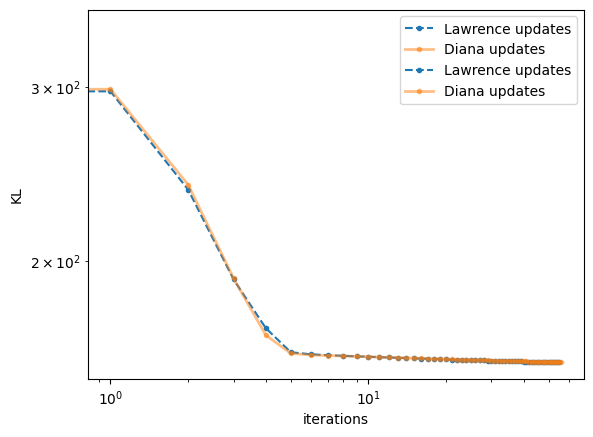

In [723]:
plt.plot(np.array(losses[-1]), marker='.', label='Lawrence updates', ls='--', color='C0')
plt.plot(np.array(losses3[-1]), marker='.', alpha=0.5, lw=2, label='Diana updates', color='C1')
plt.plot(-np.array(losses[-1]), marker='.', label='Lawrence updates', ls='--', color='C0')
plt.plot(-np.array(losses3[-1]), marker='.', alpha=0.5, lw=2, label='Diana updates', color='C1')
plt.loglog()
# plt.semilogx()
plt.legend()
plt.xlabel("iterations")
plt.ylabel(f"KL")

Text(0, 0.5, 'psi: 55th cordinate')

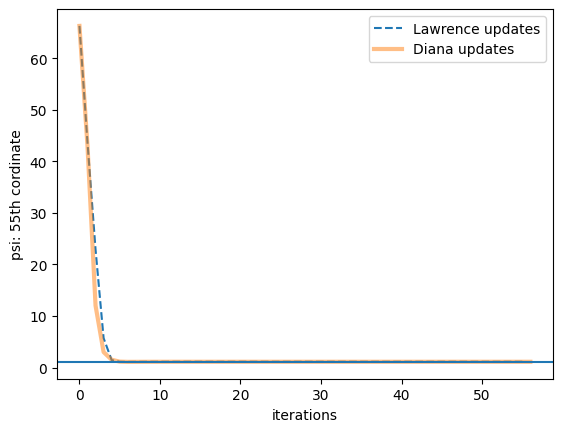

In [724]:
i = np.random.randint(D)
plt.plot(np.array(losses[0])[:, i], label='Lawrence updates', ls='--')
plt.plot(np.array(losses3[0])[:, i], label='Diana updates', alpha=0.5, lw=3)
plt.axhline(psi_true[i, i])
plt.legend()
plt.xlabel("iterations")
plt.ylabel(f"psi: {i}th cordinate")

Text(0, 0.5, 'llambda: (11, 7)th cordinate')

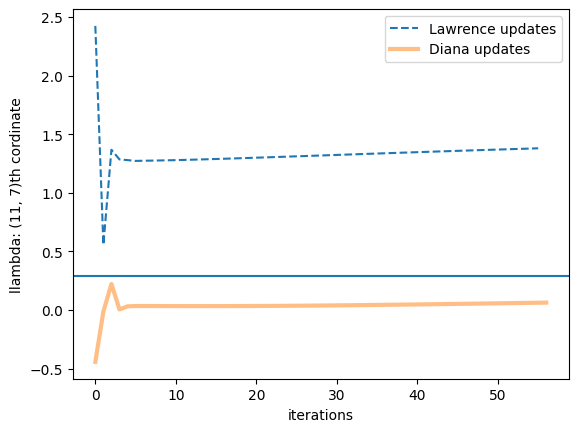

In [725]:
i = np.random.randint(D)
j = np.random.randint(K)
plt.plot(np.array(losses[1])[:, i, j], label='Lawrence updates', ls='--')
plt.plot(np.array(losses3[1])[:, i, j], label='Diana updates', alpha=0.5, lw=3)
plt.axhline(llambda_true[i, j])
plt.legend()
plt.xlabel("iterations")
plt.ylabel(f"llambda: {i, j}th cordinate")

2


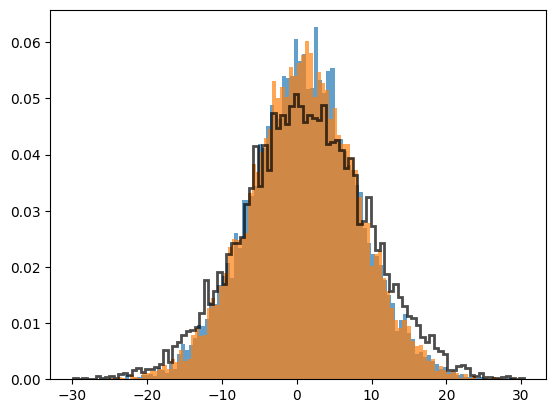

In [726]:
i = np.random.randint(D)
print(i)
plt.hist(np.random.multivariate_normal(mu, cov, 10000)[..., i], alpha=0.7, density=True, bins=100, histtype='step', lw=2, color='k');
# plt.hist(np.random.multivariate_normal(mux, covx, 10000)[..., i], alpha=0.7, density=True, bins=100);
plt.hist(np.random.multivariate_normal(mux2, covx2, 10000)[..., i], alpha=0.7, density=True, bins=100);
plt.hist(np.random.multivariate_normal(mux3, covx3, 10000)[..., i], alpha=0.7, density=True, bins=100);

[24 53 60 60  8 28 22]


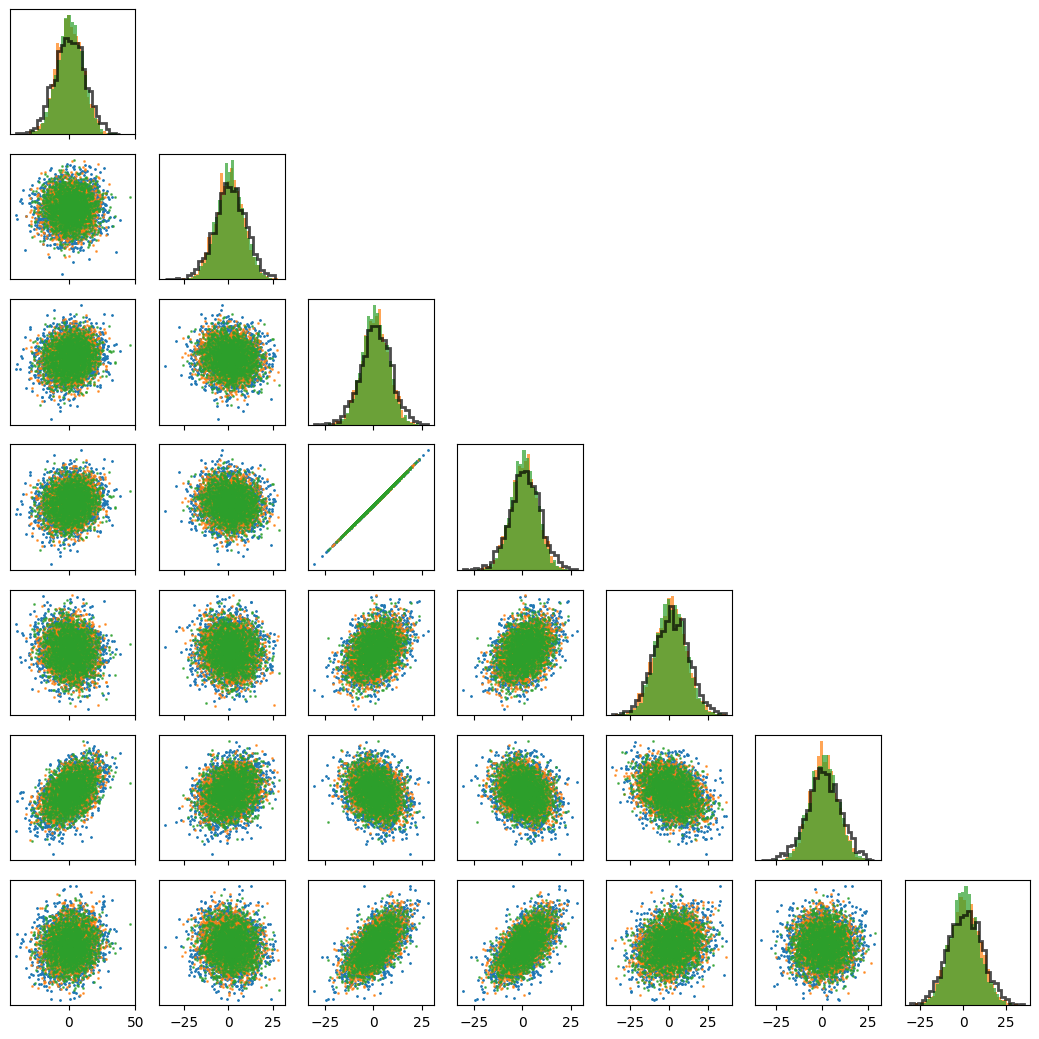

In [727]:
dplot = min(D, 7)
s = np.random.multivariate_normal(mu, cov, 2000)
s2 = np.random.multivariate_normal(mux2, covx2, 2000)
s3 = np.random.multivariate_normal(mux3, covx3, 2000)
idx = np.random.randint(0, D, dplot)
print(idx)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')

for i in range(dplot):
    for j in range(dplot):
        ii = idx[i]
        jj = idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, histtype='step', lw=2, color='k');
            ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, color='C1');
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, color='C2');
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2)
            ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()


# BAM projection

In [10]:
from bam import BAM
from gsm import GSM
from gsmvi.monitors import KLMonitor
# from gsmvi.bam_lrproject import BAM_lrproject



In [11]:

##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10, rank=4):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples


D = 128
rank = 16
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)


In [12]:
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


# alg = GSM(D, lp, lp_g)
# alg = GSM(D, lp_vmap, lp_g_vmap)
alg = bam(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
niter = 500
monitor = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
meanfit, covfit = alg.fit(key,  batch_size=16, niter=niter, regf=lambda i: 100/(1+i), monitor=monitor)

NameError: name 'bam' is not defined

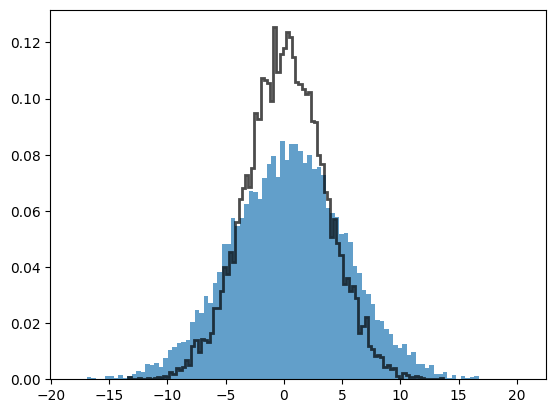

In [13]:
plt.hist(np.random.multivariate_normal(meanfit, covfit, 10000)[..., 0], bins=100, density=True, alpha=0.7);
plt.hist(ref_samples[..., 0], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


In [14]:
# lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
# lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


# alg2 = BAM_lrproject(D, lp_vmap, lp_g_vmap)
# key = jax.random.PRNGKey(2)
# niter = 500
# monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
# meanfit2, covfit2 = alg2.fit(key, rank=16, batch_size=16, n_project=256, niter=niter, regf=lambda x: 100, monitor=monitor2)

In [15]:
# plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., 0], bins=100, density=True, alpha=0.7);
# plt.hist(ref_samples[..., 0], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


## low rank fit function 

In [16]:

def _check_goodness(cov):
    is_good = False
    try:
        if (np.isnan(np.linalg.cholesky(cov))).any():
            nan_update.append(j)
        else:
            is_good = True
        return is_good
    except:
        return is_good



In [76]:
from bam import bam_lowrank_update

def low_rank_fit(key, D, lp, lp_g, rank, mean=None, cov=None, batch_size=16, 
                 niter=1000, nprint=10, regf=lambda i: 100/(1+i), retries=10, jitter=1e-6, monitor=None, verbose=True):


    if mean is None:
        mean = jnp.zeros(D)
    if cov is None:
        cov = jnp.identity(D)

    mean_lr, llambda, psi = None, None, None
    nevals = 0 
    update_function = jit(bam_lowrank_update)

    for i in range(niter + 1):
        if (i%(niter//nprint) == 0):
            print(f'Iteration {i} of {niter}')

        if monitor is not None:
            if (i%monitor.checkpoint) == 0:
                monitor(i, [mean, cov], lp, key, nevals=nevals)
                nevals = 0

        # Can generate samples from jax distribution (commented below), but using numpy is faster                                                         
        j = 0
        while True:         # Sometimes run crashes due to a bad sample. Avoid that by re-trying.                                                         
            try:
                key, key_sample = random.split(key, 2)
                np.random.seed(key_sample[0])
                samples = np.random.multivariate_normal(mean=mean, cov=cov, size=batch_size)
                vs = lp_g(samples)
                nevals += batch_size
                reg = regf(i)
                mean_new, cov_new = update_function(samples, vs, mean, cov, reg)
                cov_new += np.eye(D) * jitter # jitter covariance matrix                                                                             
                cov_new = (cov_new + cov_new.T)/2.
                break
            except Exception as e:
                if j < retries :
                    j += 1
                    print(f"Failed with exception {e}")
                    print(f"Trying again {j} of {retries}")
                else : raise e

        is_good = _check_goodness(cov_new)
        if is_good:
            mean, cov = mean_new, cov_new
            
            # x = np.random.multivariate_normal(mean, cov, 256)
            # if psi is None: 
            #     psi = jnp.diag(jnp.diag(cov))
            # if llambda is None: 
            #     llambda = np.linalg.eigh(cov)[1][:, :rank]
            #     # llambda = np.linalg.svd(cov)[0][:rank, :].T
            # _, llambda, psi = fit_lr_gaussian(x, rank, diagnosis=False,
            #                                      mu=mean, llambda=llambda, psi=psi, num_of_itr=200)
            x = np.random.multivariate_normal(mean, cov, 8)
            if psi is None: 
                psi = jnp.diag(jnp.diag(cov))
            if llambda is None: 
                llambda = np.random.normal(size=D*rank).reshape(D, rank)#*0. + 1.
                # llambda = np.random.normal(size=D*rank).reshape(D, rank)
                # llambda = np.linalg.eigh(cov)[1][:, :rank]
                # llambda = np.linalg.eigh(cov)[1][:, :rank]
                # llambda = cov[:, :rank]
            if i > 10: num_of_itr = 100
            else: num_of_itr = 100
            _, llambda, psi = fit_lr_gaussian2(x*0, mean, cov, num_of_latents=rank, diagnosis=False,
                                               llambda=llambda, psi=psi, num_of_itr=num_of_itr)
            cov = llambda@llambda.T + psi
        else:
            pass
            # if verbose: print("Bad update for covariance matrix. Revert")
            
        
      
    return mean, cov#, mean2, cov2


rank2 = int(rank)
ranklr = int(rank//4)
niter = 500
monitor2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
monitorlr = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
meanfit2, covfit2 = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=rank2, 
                                 niter=niter, monitor=monitor2, batch_size=min(D-1, 64), nprint=5)
meanfitlr, covfitlr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=ranklr, 
                                   niter=niter, monitor=monitorlr, batch_size=min(D-1, 16), nprint=5)


Iteration 0 of 500
Exception occured in monitor : sub got incompatible shapes for broadcasting: (512,), (64,)..
Appending NaN
Failed with exception sub got incompatible shapes for broadcasting: (512,), (64,).
Trying again 1 of 10
Failed with exception sub got incompatible shapes for broadcasting: (512,), (64,).
Trying again 2 of 10
Failed with exception sub got incompatible shapes for broadcasting: (512,), (64,).
Trying again 3 of 10
Failed with exception sub got incompatible shapes for broadcasting: (512,), (64,).
Trying again 4 of 10
Failed with exception sub got incompatible shapes for broadcasting: (512,), (64,).
Trying again 5 of 10
Failed with exception sub got incompatible shapes for broadcasting: (512,), (64,).
Trying again 6 of 10
Failed with exception sub got incompatible shapes for broadcasting: (512,), (64,).
Trying again 7 of 10
Failed with exception sub got incompatible shapes for broadcasting: (512,), (64,).
Trying again 8 of 10
Failed with exception sub got incompatible

TypeError: sub got incompatible shapes for broadcasting: (512,), (64,).

In [ ]:
i = np.random.randint(0, D)
print(i)
plt.hist(np.random.multivariate_normal(meanfit, covfit, 5000)[..., i], bins=100, density=True, alpha=0.7);
plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 5000)[..., i], bins=100, density=True, alpha=0.7);
# plt.hist(np.random.multivariate_normal(meanfitlr, covfitlr, 5000)[..., i], bins=100, density=True, alpha=0.7);
plt.hist(ref_samples[..., i], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


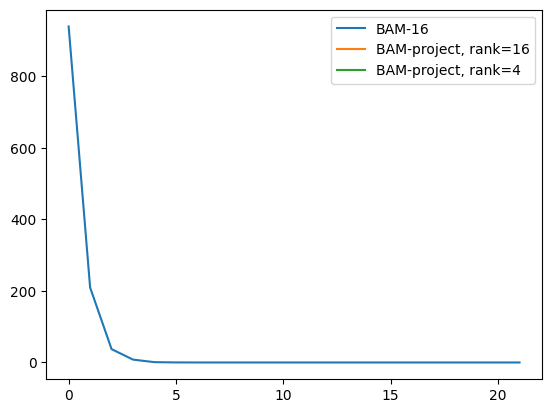

In [18]:
plt.plot(monitor.fkl, label=f'BAM-{rank}')
plt.plot(monitor2.fkl, label=f'BAM-project, rank={rank2}')
plt.plot(monitorlr.fkl, label=f'BAM-project, rank={ranklr}')
# plt.loglog()
plt.legend()

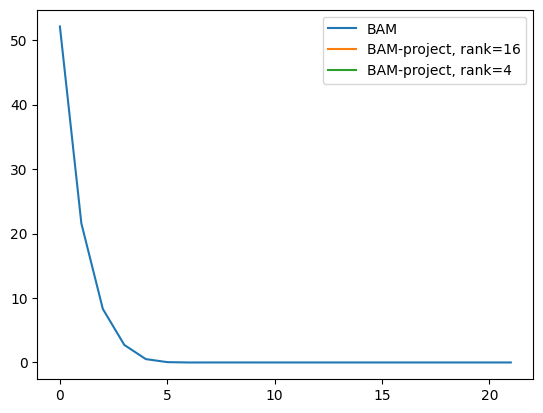

In [19]:
plt.plot(monitor.rkl, label='BAM')
plt.plot(monitor2.rkl, label=f'BAM-project, rank={rank2}')
plt.plot(monitorlr.rkl, label=f'BAM-project, rank={ranklr}')

# plt.loglog()
plt.legend()

In [20]:
s = ref_samples[:, :] #np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)
s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
# s2 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)
s3 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={rank2}");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

NameError: name 'meanfit2' is not defined

In [21]:
# fits = {}
# # ranks = [2, 4, 8, 12, 16, 20, 32]
# ranks = [ 4, 8, 12, 16, 20, 32]
# for r in ranks:
#     print(r)
#     monitorr = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
#     meanfitr, covfitr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=r, 
#                                      niter=500, monitor=monitorr, batch_size=min(D-1, 16), nprint=2)
#     fits[r] = [meanfitr, covfitr, monitorr]
    
# # mean2, cov2, mean2lr, cov2lr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=D, niter=10)

NameError: name 'ranks' is not defined

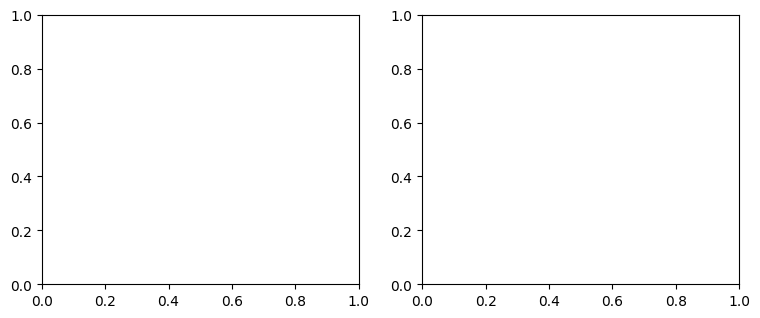

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))

for r in ranks:
    ax[0].plot(fits[r][-1].rkl, label=f'rank={r}')
    ax[1].plot(fits[r][-1].fkl, label=f'rank={r}')

ax[0].plot(monitor.rkl, color='k')
ax[1].plot(monitor.fkl, color='k', label='BAM')
ax[1].legend(ncol=2)
for axis in ax:
    axis.grid(lw=0.4)
    axis.set_xlabel('number of iterations')
    # axis.loglog()
ax[0].set_ylabel('Reverse KL')
ax[1].set_ylabel('Forward KL')
plt.suptitle(f'Target- {D} dim Gaussian with $\Sigma=D+LL^T$, L={D}x{rank}')
plt.tight_layout()


In [23]:
s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)

rplot = [rank]

ss = []
for r in rplot:
    meanfitr, covfitr = fits[r][:2]
    ss.append(np.random.multivariate_normal(meanfitr, covfitr, 2000))

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)

for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2, 
                          label=f'Target, r={rank}');
            for iss, s2 in enumerate(ss):
                ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={rplot[iss]}");
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            for iss, s2 in enumerate(ss):
                ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

NameError: name 'fits' is not defined

In [24]:
s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)

rplot = [4]

ss = []
for r in rplot:
    meanfitr, covfitr = fits[r][:2]
    ss.append(np.random.multivariate_normal(meanfitr, covfitr, 2000))

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')

for i in range(dplot):
    for j in range(dplot):
        if i == j: 
            ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2, 
                          label=f'Target, r={rank}');
            for iss, s2 in enumerate(ss):
                ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=30, label=f"rank={rplot[iss]}");
        elif j > i:
            ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2, color='k')
            for iss, s2 in enumerate(ss):
                ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

NameError: name 'fits' is not defined

In [539]:
# s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)
# s3 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
# # s3 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)
# fig, ax = plt.subplots(D, D, figsize=(D*1.5, D*1.5))

# for i in range(D):
#     for j in range(D):
#         if i == j: 
#             ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=100, histtype='step', lw=2, color='k');
#             ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=100, color='C0');
#             ax[i, i].hist(s3[..., i], alpha=0.7, density=True, bins=100, color='C1');
#         elif j > i:
#             ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2, color='k')
#             ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2, color='C0')
#             ax[j, i].plot(s3[..., i], s3[..., j], '.', alpha=0.7, ms=2, color='C1')
#         else: 
#             ax[j, i].set_axis_off()

# lr update2

In [25]:
from bam import bam_lowrank_update, compute_Q, get_sqrt
from pbam import get_diag
from time import time 

In [26]:
d = 32
k = 10
b = 8
L = np.random.normal(0, 1, k*d).reshape(d, k)*0.1
mean = np.random.normal(2, 1, d)
diag = np.diag(np.random.normal(2, 0.5, d))
cov = L@L.T + diag
x = np.random.multivariate_normal(mean, cov, 1000)

samples = np.random.random((b, d))
vs = np.random.random((b, d))
mu0 = np.random.random(d)
cov0 = np.random.random((d,d))
# A = np.random.normal(1, 1, d**2).reshape(d, d)
reg = 2 
mu1, cov1 = bam_lowrank_update(samples, vs, mu0, cov0, reg)

In [27]:
def BAM_lr_update2(samples, vs, mu0, llambda, psi, reg):


    assert len(samples.shape) == 2
    assert len(vs.shape) == 2
    S0 = np.diag(psi) + llambda@llambda.T
    B = samples.shape[0]
    xbar = jnp.mean(samples, axis=0)
    outer_map = jax.vmap(jnp.outer, in_axes=(0, 0))
    xdiff = samples - xbar
    C = jnp.mean(outer_map(xdiff, xdiff), axis=0)

    gbar = jnp.mean(vs, axis=0)
    gdiff = vs - gbar
    G = jnp.mean(outer_map(gdiff, gdiff), axis=0)

    U = reg * G + (reg)/(1+reg) * jnp.outer(gbar, gbar)
    V = S0 + reg * C + (reg)/(1+reg) * jnp.outer(mu0 - xbar, mu0 - xbar)

    # Form decomposition that is D x K                                                                                                                                                   
    Q = compute_Q((U, B))
    I = jnp.identity(B)
    VT = V.T
    A = VT.dot(Q)
    BB = 0.5*I + jnp.real(get_sqrt(A.T.dot(Q) + 0.25*I))
    BB = BB.dot(BB)
    CC = jnp.linalg.solve(BB, A.T)
    S, mu = CC, 0
    # S = VT - A @ CC
    # mu = 1/(1+reg) * mu0 + reg/(1+reg) * (jnp.matmul(S, gbar) + xbar)
    return mu, S


def BAM_lr_update3(samples, vs, mu0, llambda, psi, reg):

    ##############
    # print('new stuff now')
    assert len(samples.shape) == 2
    assert len(vs.shape) == 2
    B, D = samples.shape
    xbar = jnp.mean(samples, axis=0)
    gbar = jnp.mean(vs, axis=0)
    XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
    GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                
    # print(XT.shape, GT.shape)

    U = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1)
    Q = U.copy()
    # print('Q shape : ', Q.shape)
    
    R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1)
    # V = S0 + reg * C + (reg)/(1+reg) * jnp.outer(mu0 - xbar, mu0 - xbar)
    # V = jnp.diag(psi) + R@R.T

    QTV = (Q.T@R)@R.T + (Q.T*psi)
    VTQ = (Q.T*psi).T + R@(R.T@Q)
    # print(QTV.T / VTQ)
    Id_Q = np.identity(QTV.shape[0])
    M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
    MM = np.linalg.pinv(M@M)
    S, mu = MM@QTV, 0
    # S = V - VTQ@MM@QTV
    # mu = 1/(1+reg) * mu0 + reg/(1+reg) * (jnp.matmul(S, gbar) + xbar)

    return mu, S

llambda = np.random.random((d, k))
psi = np.random.random(d)#*0 + 1.
# mu2, cov2 = BAM_lr_update2(samples, vs, mu0, cov0, reg);
cov0 = np.diag(psi) + llambda@llambda.T
mu1, cov1 = bam_lowrank_update(samples, vs, mu0, cov0, reg)
mu2, cov2 = BAM_lr_update2(samples, vs, mu0, llambda, psi, reg);
mu3, cov3 = BAM_lr_update3(samples, vs, mu0, llambda, psi, reg);

# np.allclose(cov2, cov3)

In [28]:
%timeit mu2, cov2 = BAM_lr_update2(samples, vs, mu0, llambda, psi, reg);


10.7 ms ± 51.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%timeit mu2, cov2 = BAM_lr_update3(samples, vs, mu0, llambda, psi, reg);


1.56 ms ± 5.59 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
# k = 10
# b = 8

# t0, t1 = [], []
# ds = []
# for i in range(6, 13):
#     d = 2**i
#     print(d)
#     ds.append(d)
#     reg = 2 
#     samples = np.random.random((b, d))
#     vs = np.random.random((b, d))
#     mu0 = np.random.random(d)
#     llambda = np.random.random((d, k))
#     psi = np.random.random(d)#*0 + 1.
#     start = time()
#     for _ in range(10):
#         mu2, cov2 = BAM_lr_update2(samples, vs, mu0, llambda, psi, reg);
#     t0.append(time()-start)

#     start = time()
#     for _ in range(10):
#         mu3, cov3 = BAM_lr_update3(samples, vs, mu0, llambda, psi, reg);
#     t1.append(time()-start)


In [14]:
# plt.plot(ds, t0, marker='o')
# plt.plot(ds, t1, marker='o')
# plt.loglog()
# plt.show()
# plt.plot(ds, np.array(t0)/np.array(t1), marker='o')


In [31]:
# @jit
def em_exact_lowrank(llambda, psi, cov):
    D = llambda.shape[0]
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.pinv(np.identity(r) + alpha@llambda)
    gamma = cov@(alpha.T@beta.T)
    llambda_update = gamma @ jnp.linalg.pinv(beta + beta@alpha@gamma) 

    A = jnp.eye(D) - llambda_update @beta @ llambda.T @psi_inv
    M = A@cov@A.T + llambda_update @beta @llambda_update.T
    psi_update = jnp.diag(jnp.diagonal(M))
    
    return llambda_update, psi_update



#using mle for training
def fit_lr_gaussian2test(data, cov, num_of_latents,
                tolerance=0.001,num_of_itr=100, diagnosis=False, 
                llambda=None, psi=None):
        

    #cap the maximum number of iterations
    #initialize
    counter=0
    while counter < num_of_itr:
        print(counter)
        llambda, psi = em_exact_lowrank(llambda, psi, cov)
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return llambda, psi


In [32]:
def low_rank_kl(psi1, llambda1, psi0, R, VTQM, QTV):

    K = llambda1.shape[1]
    ltpsinv = llambda1.T*(1/psi1)
    m = jnp.identity(K) + ltpsinv@llambda1
    minv = jnp.linalg.inv(m)
    mltpsinv = minv@ltpsinv
    t0 = (psi0 + get_diag(R, R) - get_diag(VTQM, QTV.T))/psi1
    t1 = psi0*get_diag(ltpsinv.T, mltpsinv.T)
    t2 = get_diag(R@(R.T@ltpsinv.T), mltpsinv.T)
    t3 = get_diag(VTQM@(QTV@ltpsinv.T), mltpsinv.T)
    diag = (t0 - t1 - t2 + t3)
    trace_term = diag.sum()
    det_term = jnp.log(jnp.linalg.det(m)*jnp.prod(psi1))
    kl = trace_term + det_term
    return kl

def BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg,  num_of_itr = 2, tolerance=1e-3):

    ##############
    assert len(samples.shape) == 2
    assert len(vs.shape) == 2
    B, D = samples.shape
    K = llambda.shape[1]
    xbar = jnp.mean(samples, axis=0)
    gbar = jnp.mean(vs, axis=0)
    XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
    GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                

    Q = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1) #Dx(B+1)
    R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1) #Dx(K+B+1)
    QTV = (Q.T@R)@R.T + (Q.T*psi) #(B+1)xD
    Id_Q = np.identity(QTV.shape[0])
    M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
    MM = np.linalg.pinv(M@M)
    VTQM = QTV.T@MM

    # V = jnp.diag(psi) + R@R.T
    # S = V - VTQ@MM@QTV
    # llambda_check, psi_check = fit_lr_gaussian2test(None, S, num_of_latents= K, llambda=llambda, psi=np.diag(psi), num_of_itr=num_of_itr)    
    # mu = 1/(1+reg) * mu0 + reg/(1+reg) * (jnp.matmul(S, gbar) + xbar)    
    mu = 1/(1+reg) * mu0 + reg/(1+reg) * (psi*gbar + R@(R.T@gbar) - VTQM@(QTV@gbar) + xbar)    
    
    # em project 
    def get_diag(u, v):
        return jax.vmap(jnp.dot, in_axes=[0, 0])(u, v)

    counter = 0 
    Id_K = np.identity(K)
    psi0 = psi.copy()
    first_term_1 = psi0 + get_diag(R, R) - get_diag(VTQM, QTV.T) #diag of cov for psi    
    current_kl = 0
    
    for counter in range(num_of_itr):
        psi_inv = psi**-1
        C = np.linalg.pinv(Id_K + (llambda.T *psi_inv)@llambda) #KxK
        J = C@(llambda.T*psi_inv) #KxD
        VJT = (J*psi0).T + R@(R.T@J.T) #DxK
        SJT = VJT - VTQM@(QTV@J.T)   #SigmaJT 
        # print(SJT.shape, VTQM.shape, (QTV@J.T).shape) 
        llambda_update = SJT @ np.linalg.pinv(C + J@SJT)
        # print(np.allclose(llambda_update, llambda_check))

        # psi update here        
        first_term_2 = -2* get_diag(SJT, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(SJT, llambda_update.T)

        Mint = J@SJT
        def contractM(a):
            return a@Mint@a
        first_term_3 = jax.vmap(contractM, in_axes=[0])(llambda_update) 
        # Atest = llambda_update@J@S@J.T@llambda_update.T
        # print(first_term_3/np.diag(Atest))
        first_term = first_term_1 + first_term_2 + first_term_3
        
        lupdateC = llambda_update @C 
        second_term = get_diag(lupdateC, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(lupdateC, llambda_update.T)
        psi_update = first_term + second_term
        
        #use lower bound to determine if convergeda
        old_kl = current_kl
        current_kl = low_rank_kl(psi_update, llambda_update, psi0, R, VTQM, QTV)
        if old_kl and np.abs(current_kl/old_kl-1)<tolerance:
            print(f'{counter} iterations to reach convergence\n')
            llambda, psi = llambda_update, psi_update
            return mu, llambda, psi
        
        llambda, psi = llambda_update, psi_update
        
        # A = jnp.eye(D) - llambda_update @C @ llambda.T *psi_inv
        # A = A@S@A.T + llambda_update @C @llambda_update.T        
        # print(psi_update/np.diag(A))
        
    # print(llambda_update/llambda_check)
    # print(psi_update/np.diag(psi_check))
    return mu, llambda, psi


llambda = np.random.random((d, k))
psi = np.random.random(d)#*0 + 1.
# mu2, cov2 = BAM_lr_update2(samples, vs, mu0, cov0, reg);
cov0 = np.diag(psi) + llambda@llambda.T
mu3, llambda_update, psi_upadte = BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg, num_of_itr=10);



In [33]:
# k = 10
# b = 8

# t0, t1 = [], []
# ds = []
# for i in range(6, 13):
#     d = 2**i
#     print(d)
#     ds.append(d)
#     reg = 2 
#     samples = np.random.random((b, d))
#     vs = np.random.random((b, d))
#     mu0 = np.random.random(d)
#     llambda = np.random.random((d, k))
#     psi = np.random.random(d)#*0 + 1.
#     start = time()
#     for _ in range(10):
#         mu2, cov2 = BAM_lr_update2(samples, vs, mu0, llambda, psi, reg);
#     t0.append(time()-start)

#     start = time()
#     for _ in range(10):
#         mu3, llambda_update, psi_update = BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg);
#     t1.append(time()-start)

# ds = np.array(ds)
# t0 = np.array(t0)
# t1 = np.array(t1)

In [34]:
# plt.plot(ds, t0, marker='o')
# # plt.plot(ds, 1e-5*np.array(ds)**2, marker='o')
# # plt.plot(ds, 1e-3*np.array(ds)**1, marker='o')
# plt.plot(ds, t1, marker='o')
# plt.loglog()
# plt.show()
# plt.plot(ds, np.array(t0)/np.array(t1), marker='o')


In [35]:
# # plt.plot(ds, t0/t0[0], marker='o')
# plt.plot(ds, t1/t1[0], marker='o')
# plt.xlabel('Dimensions')
# plt.ylabel('time for update')

In [36]:
# from bam import bam_lowrank_update
from bam import bam_lowrank_update

def low_rank_fit_final(key, D, lp, lp_g, rank, mean=None, llambda=None, psi=None, batch_size=16, tolerance=1e-3, niter_em=10,
                 niter=1000, nprint=10, regf=lambda i: 100/(1+i), retries=10, jitter=1e-6, monitor=None, verbose=True):


    if mean is None:
        mean = jnp.zeros(D)

    nevals = 0 

    for i in range(niter + 1):
        if (i%(niter//nprint) == 0):
            print(f'Iteration {i} of {niter}')

        if monitor is not None:
            if (i%monitor.checkpoint) == 0:
                monitor(i, [mean, cov], lp, key, nevals=nevals)
                nevals = 0

        # Can generate samples from jax distribution (commented below), but using numpy is faster                                                         
        j = 0
        while True:         # Sometimes run crashes due to a bad sample. Avoid that by re-trying.                                                         
            try:
                key, key_sample = random.split(key, 2)
                np.random.seed(key_sample[0])
                samples = np.random.multivariate_normal(mean=mean, cov=cov, size=batch_size)
                vs = lp_g(samples)
                nevals += batch_size
                reg = regf(i)
                mean, llambda, psi = BAM_lr_project_test(samples, vs, mean, llambda=llambda, psi=psi, reg=reg, 
                                                         tolerance=tolerance, num_of_itr=niter_em)
                
#                 mean_new, cov_new = update_function(samples, vs, mean, cov, reg)
#                 cov_new += np.eye(D) * jitter # jitter covariance matrix                                                                             
#                 cov_new = (cov_new + cov_new.T)/2.
                break
            except Exception as e:
                if j < retries :
                    j += 1
                    print(f"Failed with exception {e}")
                    print(f"Trying again {j} of {retries}")
                else : raise e

#         is_good = _check_goodness(cov_new)
#         if is_good:
#             mean, cov = mean_new, cov_new
            
#             # x = np.random.multivariate_normal(mean, cov, 256)
#             # if psi is None: 
#             #     psi = jnp.diag(jnp.diag(cov))
#             # if llambda is None: 
#             #     llambda = np.linalg.eigh(cov)[1][:, :rank]
#             #     # llambda = np.linalg.svd(cov)[0][:rank, :].T
#             # _, llambda, psi = fit_lr_gaussian(x, rank, diagnosis=False,
#             #                                      mu=mean, llambda=llambda, psi=psi, num_of_itr=200)
#             x = np.random.multivariate_normal(mean, cov, 8)
#             if psi is None: 
#                 psi = jnp.diag(jnp.diag(cov))
#             if llambda is None: 
#                 llambda = np.random.normal(size=D*rank).reshape(D, rank)#*0. + 1.
#                 # llambda = np.random.normal(size=D*rank).reshape(D, rank)
#                 # llambda = np.linalg.eigh(cov)[1][:, :rank]
#                 # llambda = np.linalg.eigh(cov)[1][:, :rank]
#                 # llambda = cov[:, :rank]
#             if i > 10: num_of_itr = 100
#             else: num_of_itr = 100
#             _, llambda, psi = fit_lr_gaussian2(x*0, mean, cov, num_of_latents=rank, diagnosis=False,
#                                                llambda=llambda, psi=psi, num_of_itr=num_of_itr)
#             cov = llambda@llambda.T + psi
        # else:
        #     pass
            # if verbose: print("Bad update for covariance matrix. Revert")
            
        
      
    return mean, llambda, psi#, mean2, cov2




D = 128
rank = 16
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)


rank2 = int(rank)
ranklr = int(rank//4)
niter = 50
# monitor2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
# monitorlr = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
psi0 = np.random.random(D)
llambda0 = np.random.random((D, rank2))
meanfit2, llambda2, psi2 = low_rank_fit_final(key, D, lp_vmap, lp_g_vmap, rank=rank2, psi=psi0, llambda=llambda0,
                                 niter=niter, monitor=None, batch_size=min(D-1, 64), nprint=5, tolerance=0, niter_em=10)
covfit2 = np.diag(psi2) + llambda2@llambda2.T                             
llambda0 = np.random.random((D, ranklr))
meanfitlr, llambdalr, psilr = low_rank_fit_final(key, D, lp_vmap, lp_g_vmap, rank=ranklr, psi=psi0, llambda=llambda0,
                                   niter=niter, monitor=None, batch_size=min(D-1, 16), nprint=5, tolerance=0, niter_em=10)
covfitlr = np.diag(psilr) + llambdalr@llambdalr.T                             


Iteration 0 of 50
Iteration 10 of 50
Iteration 20 of 50
Iteration 30 of 50
Iteration 40 of 50
Iteration 50 of 50
Iteration 0 of 50
Iteration 10 of 50
Iteration 20 of 50
Iteration 30 of 50
Iteration 40 of 50
Iteration 50 of 50


[102   1  80  26  56]


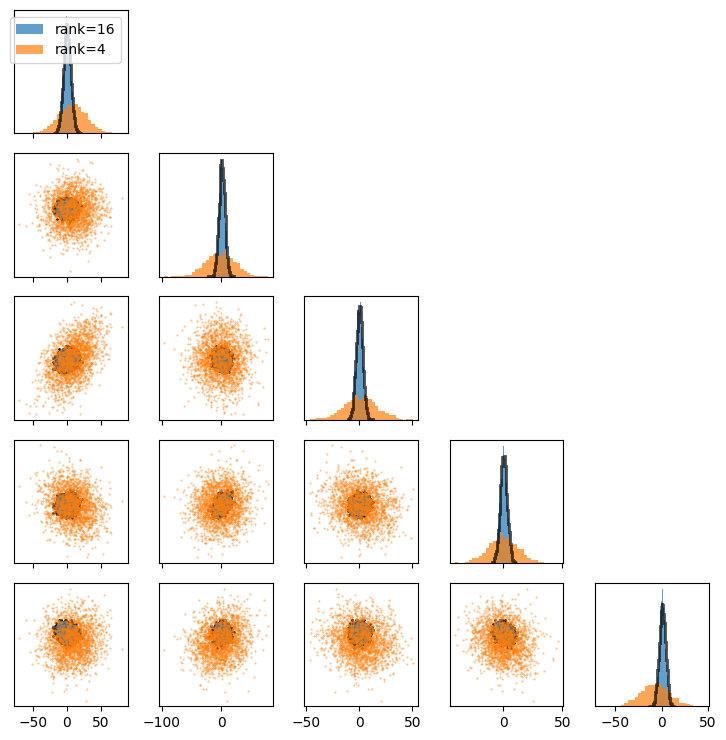

In [37]:
s = ref_samples[:, :] #np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)
s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
# s2 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)
s3 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={rank2}");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=1)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

# logp

In [38]:
d = 512
k = 10
b = 8
L = np.random.normal(0, 1, k*d).reshape(d, k)*0.1
mean = np.random.normal(2, 1, d)
diag = np.diag(np.random.normal(2, 0.5, d))
cov = L@L.T + diag
x = np.random.multivariate_normal(mean, cov, 1000)

psi, llambda = np.diagonal(diag), L
# samples = np.random.random((b, d))
# vs = np.random.random((b, d))

In [39]:
def detm(psi, llambda):
    m = (llambda.T*(1/psi))@llambda
    m = np.identity(m.shape[0]) + m
    return jnp.linalg.det(m)*jnp.prod(psi)

def logp_lr(y, mu, psi, llambda):

    D, K = llambda.shape
    x = y - mu
    first_term = jnp.dot(x, x/psi)
    ltpsinv = llambda.T*(1/psi)
    m = jnp.identity(K) + ltpsinv@llambda
    minv = jnp.linalg.inv(m)
    res= (ltpsinv@x)
    second_term = res.T@minv@res
    logexp = -0.5 * (first_term - second_term)
    logdet = - 0.5 * jnp.log(jnp.linalg.det(m)*jnp.prod(psi))
    logp = logexp + logdet - 0.5*D*np.log(2*pi)
    return logp

# detm(psi, llambda), np.linalg.det(cov)


In [40]:
i = np.random.randint(1000)
print(i)
logp_lr(x[i], mean, psi, llambda)/ MultivariateNormal(mean, cov).log_prob(x[i])

125


Array(1., dtype=float64)

In [41]:
%timeit logp_lr(x[i], mean, psi, llambda)


499 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [189]:
%timeit MultivariateNormal(mean, cov).log_prob(x[i])

4.55 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [190]:
%timeit jnp.linalg.det(cov)

4.31 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [191]:
%timeit detm(psi, llambda)

176 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
# from bam import get_sqrt
d = 512
b = 32
mat = np.random.random((b, b))
V = np.random.random((d, b))
I = np.identity(d)

jnp.matmul(V, jnp.linalg.inv(mat))
jnp.linalg.solve(mat, V.T);

In [16]:
jnp.matmul(V, jnp.linalg.inv(mat)) / jnp.linalg.solve(mat.T, V.T).T

Array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float64)

In [ ]:
%timeit jnp.matmul(V, jnp.linalg.inv(mat))
%timeit jnp.linalg.solve(mat, V.T);

In [22]:
a, b = np.random.uniform(size=10), np.random.uniform(size=10)
jnp.maximum(a, b)

Array([0.38066325, 0.77972753, 0.42192893, 0.78614637, 0.88859219,
       0.33261032, 0.77887428, 0.52577724, 0.78172291, 0.66659113],      dtype=float64)

In [23]:
a, b

(array([0.38066325, 0.65032592, 0.03541904, 0.78614637, 0.14430256,
        0.33261032, 0.77887428, 0.52577724, 0.74540884, 0.66659113]),
 array([0.22681264, 0.77972753, 0.42192893, 0.26749933, 0.88859219,
        0.21999954, 0.25343365, 0.29535895, 0.78172291, 0.24309841]))

# KL

In [230]:
# def BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg,  num_of_itr = 2):

#     ##############
#     assert len(samples.shape) == 2
#     assert len(vs.shape) == 2
#     B, D = samples.shape
#     K = llambda.shape[1]
#     xbar = jnp.mean(samples, axis=0)
#     gbar = jnp.mean(vs, axis=0)
#     XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
#     GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                

#     Q = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1) #Dx(B+1)
#     R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1) #Dx(K+B+1)
#     QTV = (Q.T@R)@R.T + (Q.T*psi) #(B+1)xD
#     Id_Q = np.identity(QTV.shape[0])
#     M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
#     MM = np.linalg.pinv(M@M)
#     VTQM = QTV.T@MM
    
#     V = jnp.diag(psi) + R@R.T
#     S = V - VTQ@MM@QTV
    
#     # llambda_check, psi_check = fit_lr_gaussian2test(None, S, num_of_latents= K, llambda=llambda, psi=np.diag(psi), num_of_itr=num_of_itr)    
#     # mu = 1/(1+reg) * mu0 + reg/(1+reg) * (jnp.matmul(S, gbar) + xbar)    
#     mu = 1/(1+reg) * mu0 + reg/(1+reg) * (psi*gbar + R@(R.T@gbar) - VTQM@(QTV@gbar) + xbar)    
    
#     # em project 
#     def get_diag(u, v):
#         return jax.vmap(jnp.dot, in_axes=[0, 0])(u, v)

#     counter = 0 
#     Id_K = np.identity(K)
#     psi0 = psi.copy()
#     first_term_1 = psi0 + get_diag(R, R) - get_diag(VTQM, QTV.T) #diag of cov for psi
    
#     for counter in range(num_of_itr):
#         psi_inv = psi**-1
#         C = np.linalg.pinv(Id_K + (llambda.T *psi_inv)@llambda) #KxK
#         J = C@(llambda.T*psi_inv) #KxD
#         VJT = (J*psi0).T + R@(R.T@J.T) #DxK
#         SJT = VJT - VTQM@(QTV@J.T)   #SigmaJT 
#         # print(SJT.shape, VTQM.shape, (QTV@J.T).shape) 
#         llambda_update = SJT @ np.linalg.pinv(C + J@SJT)
#         # print(np.allclose(llambda_update, llambda_check))

#         # psi update here        
#         first_term_2 = -2* get_diag(SJT, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(SJT, llambda_update.T)

#         Mint = J@SJT
#         def contractM(a):
#             return a@Mint@a
#         first_term_3 = jax.vmap(contractM, in_axes=[0])(llambda_update) 
#         # Atest = llambda_update@J@S@J.T@llambda_update.T
#         # print(first_term_3/np.diag(Atest))
#         first_term = first_term_1 + first_term_2 + first_term_3
        
#         lupdateC = llambda_update @C 
#         second_term = get_diag(lupdateC, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(lupdateC, llambda_update.T)
#         psi_update = first_term + second_term
        
#         llambda, psi = llambda_update, psi_update
        
#         # A = jnp.eye(D) - llambda_update @C @ llambda.T *psi_inv
#         # A = A@S@A.T + llambda_update @C @llambda_update.T        
#         # print(psi_update/np.diag(A))
        
#     # print(llambda_update/llambda_check)
#     # print(psi_update/np.diag(psi_check))
#     return mu, llambda, psi


# llambda = np.random.random((d, k))
# psi = np.random.random(d)#*0 + 1.
# # mu2, cov2 = BAM_lr_update2(samples, vs, mu0, cov0, reg);
# cov0 = np.diag(psi) + llambda@llambda.T
# mu3, llambda_update, psi_upadte = BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg, num_of_itr=5);



In [534]:
from gsmvi.bam import get_sqrt

D = 32
K = 4 
B = 8
reg = 1.0
llambda = np.random.random((D, K))
psi = np.random.random(D) #+ 1.
llambda1 = np.random.random((D, K))
psi1 = np.random.random(D)#*0 + 1.
cov1 = np.diag(psi1) + llambda1@llambda1.T

mu0 = np.random.random(D)#*0 + 1.
cov0 = np.diag(psi) + llambda@llambda.T
samples = np.random.random((B, D))
vs = np.random.random((B, D))


xbar = jnp.mean(samples, axis=0)
gbar = jnp.mean(vs, axis=0)
XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                

Q = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1) #Dx(B+1)
R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1) #Dx(K+B+1)
QTV = (Q.T@R)@R.T + (Q.T*psi) #(B+1)xD
Id_Q = np.identity(QTV.shape[0])
M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
MM = np.linalg.pinv(M@M)
VTQM = QTV.T@MM

V = jnp.diag(psi) + R@R.T
S = V - VTQM@QTV


In [542]:
R.shape, VTQM.shape, QTV.shape

((32, 13), (32, 9), (9, 32))

In [539]:
x = np.random.multivariate_normal(np.zeros(D), S, 1000)

eps = np.random.normal(0, 1, size=(1000, D))
z = np.random.normal(0, 1, size=(1000, K))
samples = psi**0.5 * eps + (llambda@z.T).T

y = 

SyntaxError: invalid syntax (793299882.py, line 7)

In [57]:
np.allclose(np.linalg.solve(M@M, QTV).T, VTQM)

True

In [51]:
VTQM.shape

(32, 9)

In [43]:
Ainv = np.linalg.inv(np.diag(psi1) + llambda1@llambda1.T)
np.diag(S@Ainv)

array([2.58425281, 4.84259023, 2.81897121, 0.70684447, 4.89488136,
       2.78188339, 1.23616815, 6.76071977, 3.85349304, 2.17145115,
       0.49448778, 0.49555273, 1.22985919, 6.20987093, 2.67178664,
       1.02046376, 5.40646026, 2.3309711 , 3.70139516, 1.69401026,
       1.20365208, 2.73521237, 5.5459978 , 0.88280751, 1.48108173,
       0.37611244, 0.66668646, 1.55136554, 2.33528286, 1.21543229,
       1.5547789 , 0.90598817])

In [58]:
ltpsinv = llambda1.T*(1/psi1)
m = jnp.identity(K) + ltpsinv@llambda1
minv = jnp.linalg.inv(m)
mltpsinv = minv@ltpsinv

(np.diag(1/psi1) - ltpsinv.T@mltpsinv)/ Ainv

Array([[  0.98414723,  -0.19295238,   1.43886727, ...,   0.35881892,
          3.4224556 ,  -6.53798616],
       [ -0.19295238,   0.25579794,  -0.75138973, ...,   0.09416911,
         -2.98128311, -11.64814375],
       [  1.43886727,  -0.75138973,   0.63366146, ...,   0.22235516,
          0.41578748,  18.14112482],
       ...,
       [  0.35881892,   0.09416911,   0.22235516, ...,   1.14889511,
          0.1667101 ,  -2.44304664],
       [  3.4224556 ,  -2.98128311,   0.41578748, ...,   0.1667101 ,
          0.90541521,   3.35637904],
       [ -6.53798616, -11.64814375,  18.14112482, ...,  -2.44304664,
          3.35637904,   5.76632022]], dtype=float64)

In [61]:
minv = jnp.linalg.inv(m)
mltpsinv = minv@ltpsinv
np.linalg.solve(m, ltpsinv)/mltpsinv

Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],      dtype=float64)

In [45]:
from pbam import get_diag


In [46]:
t0 = (psi + get_diag(R, R) - get_diag(VTQM, QTV.T))/psi1
# t1 = psi*get_diag(ltpsinv.T, mltpsinv.T)
# # t2 = diagonal((S-np.diag(psi))@ltpsinv.T@mltpsinv)
# t2 = get_diag(R@(R.T@ltpsinv.T), mltpsinv.T)
# t3 = get_diag(VTQM@(QTV@ltpsinv.T), mltpsinv.T)
t1 = psi*get_diag(ltpsinv.T, mltpsinv.T)
t2 = get_diag(R@(R.T@ltpsinv.T), mltpsinv.T)
t3 = get_diag(VTQM@(QTV@ltpsinv.T), mltpsinv.T)
(t0 - t1 - t2 + t3)/np.diag(S@Ainv)

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float64)

In [47]:
def low_rank_kl(psi1, llambda1, psi0, R, VTQM, QTV):

    K = llambda1.shape[1]
    ltpsinv = llambda1.T*(1/psi1)
    m = jnp.identity(K) + ltpsinv@llambda1
    minv = jnp.linalg.inv(m)
    mltpsinv = minv@ltpsinv
    t0 = (psi0 + get_diag(R, R) - get_diag(VTQM, QTV.T))/psi1
    t1 = psi0*get_diag(ltpsinv.T, mltpsinv.T)
    t2 = get_diag(R@(R.T@ltpsinv.T), mltpsinv.T)
    t3 = get_diag(VTQM@(QTV@ltpsinv.T), mltpsinv.T)
    diag = (t0 - t1 - t2 + t3)
    trace_term = diag.sum()
    det_term = jnp.log(jnp.linalg.det(m)*jnp.prod(psi))
    kl = trace_term + det_term
    return kl

In [48]:
low_rank_kl(psi1, llambda1, psi, R, VTQM, QTV)



Array(58.11834926, dtype=float64)

In [49]:
for _ in range(10):
    llambda1 = np.random.random((D, K))
    psi1 = np.random.random(D)#*0 + 1.
    cov1 = np.diag(psi1) + llambda1@llambda1.T
    x = MultivariateNormal(mu0, cov0).sample(key, (1000,))
    k0 = (MultivariateNormal(mu0, cov0).log_prob(x) -    MultivariateNormal(mu0, cov1).log_prob(x)).mean()
    k1 = low_rank_kl(psi1, llambda1, psi, R, VTQM, QTV)
    print(k0, k1, k0-k1)

96.29986722056259 198.5218626719343 -102.2219954513717
25.02714335552831 60.038723966145255 -35.011580610616946
37.22804356375498 84.2684144187468 -47.04037085499182
42.81822842040913 105.94816779213119 -63.12993937172206
40.72045823119104 92.12495022702906 -51.40449199583802
35.006292475217386 85.37403337689152 -50.36774090167413
26.694294274277727 64.2865116593756 -37.59221738509788
24.088522811740106 52.021747670738584 -27.93322485899848
36.33325301886196 81.36217955529709 -45.02892653643513
32.20495017730371 65.82970801033193 -33.62475783302822


# projected GSM

In [ ]:

# def BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg,  num_of_itr = 2, tolerance=1e-3):

#     ##############
#     assert len(samples.shape) == 2
#     assert len(vs.shape) == 2
#     B, D = samples.shape
#     K = llambda.shape[1]
#     xbar = jnp.mean(samples, axis=0)
#     gbar = jnp.mean(vs, axis=0)
#     XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
#     GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                

#     Q = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1) #Dx(B+1)
#     R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1) #Dx(K+B+1)
#     QTV = (Q.T@R)@R.T + (Q.T*psi) #(B+1)xD
#     Id_Q = np.identity(QTV.shape[0])
#     M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
#     MM = np.linalg.pinv(M@M)
#     VTQM = QTV.T@MM

#     # V = jnp.diag(psi) + R@R.T
#     # S = V - VTQ@MM@QTV
#     # llambda_check, psi_check = fit_lr_gaussian2test(None, S, num_of_latents= K, llambda=llambda, psi=np.diag(psi), num_of_itr=num_of_itr)    
#     # mu = 1/(1+reg) * mu0 + reg/(1+reg) * (jnp.matmul(S, gbar) + xbar)    
#     mu = 1/(1+reg) * mu0 + reg/(1+reg) * (psi*gbar + R@(R.T@gbar) - VTQM@(QTV@gbar) + xbar)    
    
#     # em project 
#     def get_diag(u, v):
#         return jax.vmap(jnp.dot, in_axes=[0, 0])(u, v)

#     counter = 0 
#     Id_K = np.identity(K)
#     psi0 = psi.copy()
#     first_term_1 = psi0 + get_diag(R, R) - get_diag(VTQM, QTV.T) #diag of cov for psi    
#     current_kl = 0
    
#     for counter in range(num_of_itr):
#         psi_inv = psi**-1
#         C = np.linalg.pinv(Id_K + (llambda.T *psi_inv)@llambda) #KxK
#         J = C@(llambda.T*psi_inv) #KxD
#         VJT = (J*psi0).T + R@(R.T@J.T) #DxK
#         SJT = VJT - VTQM@(QTV@J.T)   #SigmaJT 
#         # print(SJT.shape, VTQM.shape, (QTV@J.T).shape) 
#         llambda_update = SJT @ np.linalg.pinv(C + J@SJT)
#         # print(np.allclose(llambda_update, llambda_check))

#         # psi update here        
#         first_term_2 = -2* get_diag(SJT, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(SJT, llambda_update.T)

#         Mint = J@SJT
#         def contractM(a):
#             return a@Mint@a
#         first_term_3 = jax.vmap(contractM, in_axes=[0])(llambda_update) 
#         # Atest = llambda_update@J@S@J.T@llambda_update.T
#         # print(first_term_3/np.diag(Atest))
#         first_term = first_term_1 + first_term_2 + first_term_3
        
#         lupdateC = llambda_update @C 
#         second_term = get_diag(lupdateC, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(lupdateC, llambda_update.T)
#         psi_update = first_term + second_term
        
#         #use lower bound to determine if convergeda
#         old_kl = current_kl
#         current_kl = low_rank_kl(psi_update, llambda_update, psi0, R, VTQM, QTV)
#         if old_kl and np.abs(current_kl/old_kl-1)<tolerance:
#             print(f'{counter} iterations to reach convergence\n')
#             llambda, psi = llambda_update, psi_update
#             return mu, llambda, psi
        
#         llambda, psi = llambda_update, psi_update
        
#         # A = jnp.eye(D) - llambda_update @C @ llambda.T *psi_inv
#         # A = A@S@A.T + llambda_update @C @llambda_update.T        
#         # print(psi_update/np.diag(A))
        
#     # print(llambda_update/llambda_check)
#     # print(psi_update/np.diag(psi_check))
#     return mu, llambda, psi


# llambda = np.random.random((d, k))
# psi = np.random.random(d)#*0 + 1.
# # mu2, cov2 = BAM_lr_update2(samples, vs, mu0, cov0, reg);
# cov0 = np.diag(psi) + llambda@llambda.T
# mu3, llambda_update, psi_upadte = BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg, num_of_itr=10);



In [30]:
def gsm_update_single_og(sample, v, mu0, psi, llambda):
    '''returns GSM update to mean and covariance matrix for a single sample
    '''
        
    D, K = llambda.shape

    S0 = np.diag(psi) + llambda@llambda.T
    S0v = jnp.matmul(S0, v)
    vSv = jnp.matmul(v, S0v)
    mu_v = jnp.matmul((mu0 - sample), v)
    rho = 0.5 * jnp.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
    eps0 = S0v - mu0 + sample

    #mu update
    mu_vT = jnp.outer((mu0 - sample), v)
    den = 1 + rho + mu_v
    I = jnp.eye(sample.shape[0])
    mu_update = 1/(1 + rho) * jnp.matmul(( I - mu_vT / den), eps0)
    mu = mu0 + mu_update
    #S update
    Supdate_0 =  jnp.outer((mu0-sample), (mu0-sample))
    Supdate_1 =  jnp.outer((mu-sample), (mu-sample))
    S_update = (Supdate_0 - Supdate_1)
    S = S0 + S_update

    psi0 = psi.copy()
    Id_K = np.eye(K)    
    Id_D = np.eye(D)
    for counter in range(1):
        psi_inv = psi**-1
        C = np.linalg.pinv(Id_K + (llambda.T *psi_inv)@llambda) #KxK
        J = C@(llambda.T*psi_inv) #KxD
        SJT = S@J.T
        llambda_update = SJT @ np.linalg.pinv(C + J@SJT)

        first_term = np.diagonal((Id_D - llambda_update@J)@S@(Id_D - llambda_update@J).T)
        second_term = np.diagonal(llambda_update@C@llambda_update.T)
        psi_update = first_term + second_term
        
        llambda, psi = llambda_update, psi_update
        

    return llambda_update, psi_update

    return mu_update, S_update


def gsm_update_single_lr(sample, v, mu0, psi, llambda):
    '''returns GSM update to mean and covariance matrix for a single sample
    '''
    D, K = llambda.shape
    S0v = psi*v + llambda@(llambda.T@v)
    vSv = v@S0v
    
    mu_v = jnp.matmul((mu0 - sample), v)
    rho = 0.5 * jnp.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
    eps0 = S0v - mu0 + sample

    #mu update
    mu_vT = jnp.outer((mu0 - sample), v)
    den = 1 + rho + mu_v
    I = jnp.eye(sample.shape[0])
    mu_update = 1/(1 + rho) * (eps0 - 1/den * (mu0 - sample) * (v@eps0))
    mu = mu0 + mu_update

    #S update
    Supdate_0 =  (mu0-sample).reshape(-1,1)
    Supdate_1 =  (mu-sample).reshape(-1,1)
    alpha = np.concatenate([llambda.copy(), Supdate_0], axis=1)
    beta = Supdate_1.copy()
    
    psi0 = psi.copy()
    Id_K = np.eye(K)    
#     psi0 = psi.copy()
    first_term_1 = psi0 + get_diag(alpha, alpha) - get_diag(beta, beta) #diag of cov for psi    
    for counter in range(1):
        psi_inv = psi**-1
        C = np.linalg.pinv(Id_K + (llambda.T *psi_inv)@llambda) #KxK
        J = C@(llambda.T*psi_inv) #KxD
        SJT = (psi0*J).T + alpha @ (alpha.T@J.T) - beta@(beta.T@J.T)
        llambda_update = SJT @ np.linalg.pinv(C + J@SJT)
        # print(np.allclose(llambda_update, llambda_check))
        
        # psi update here        
        first_term_2 = -2* get_diag(SJT, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(SJT, llambda_update.T)

        Mint = J@SJT
        def contractM(a):
            return a@Mint@a
        first_term_3 = jax.vmap(contractM, in_axes=[0])(llambda_update) 
        # Atest = llambda_update@J@S@J.T@llambda_update.T
        # print(first_term_3/np.diag(Atest))
        first_term = first_term_1 + first_term_2 + first_term_3
        
        lupdateC = llambda_update @C 
        second_term = get_diag(lupdateC, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(lupdateC, llambda_update.T)
        psi_update = first_term + second_term
        

    return llambda_update, psi_update

    
    return mu_update, Supdate_0, Supdate_1




In [36]:
d, k = 32, 8

a = np.random.random(d)
b = np.random.random(d)
mean = np.random.random(d)
psi = np.random.random(d)
llambda = np.random.random((d, k))
cov = np.diag(psi) + llambda@llambda.T
samples = np.random.multivariate_normal(mean, cov, 1000)

In [32]:
J = np.random.random((k, d))

In [39]:
gsm_update_single_og(a, b, c, psi, llambda)[0]/ gsm_update_single_lr(a, b, c, psi, llambda)[0];

NameError: name 'c' is not defined

In [40]:
gsm_update_single_og(a, b, mean, psi, llambda)[1]/ gsm_update_single_lr(a, b, mean, psi, llambda)[1]

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float64)

## exp


In [65]:
from gsmvi.gsm import GSM
from gsmvi.bam import BAM
from gsmvi.pbam import PBAM
from pgsm import PGSM

In [158]:

##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10, rank=4):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples



D = 512
rank = 32
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


In [159]:
alg = GSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanfit, covfit = alg.fit(key,  batch_size=2, niter=2000, monitor=monitor, nprint=5)
sgsm = np.random.multivariate_normal(meanfit, covfit, 2000)


Iteration 0 of 2000
Iteration 400 of 2000
Iteration 800 of 2000
Iteration 1200 of 2000
Iteration 1600 of 2000
Iteration 2000 of 2000


In [183]:
#
alg2 = PBAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
ranklr = rank

monitor2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanpbam, psipbam, llambdpbam = alg2.fit(key, rank=ranklr, regf=lambda x: 10,
                           batch_size=2, niter=3000, monitor=monitor2, nprint=5, niter_em=21)
covpbam = np.diag(psipbam) + llambdpbam@llambdpbam.T
spbam = np.random.multivariate_normal(meanpbam, covpbam, 2000)

Iteration 0 of 3000. Time taken :  3.0994415283203125e-06
compiled
time for first 10 iterations :  0.4692084789276123
Iteration 600 of 3000. Time taken :  34.69344782829285
Iteration 1200 of 3000. Time taken :  63.70221400260925
Iteration 1800 of 3000. Time taken :  93.01386547088623
Iteration 2400 of 3000. Time taken :  122.6698808670044
Iteration 3000 of 3000. Time taken :  151.96162056922913
Total number of projections :  60020


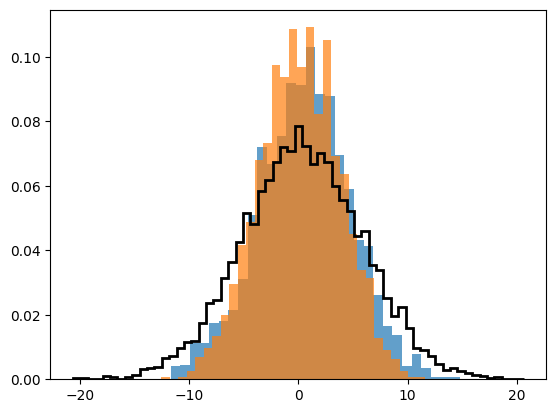

In [174]:
i = 0 

plt.hist(ref_samples[..., i], bins='auto', density=True, color='k', histtype='step', lw=2);
plt.hist(sgsm[..., i], bins='auto', density=True,alpha=0.7);
plt.hist(spbam[..., i], bins='auto', density=True,alpha=0.7);

In [182]:
alg3 = PGSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
# ranklr = rank//2

monitor3 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanpgsm, psipgsm, llambdapgsm = alg3.fit(key, rank=ranklr,  batch_size=2, niter=3000, monitor=monitor3, nprint=5, niter_em=21)
covpgsm = np.diag(psipgsm) + llambdapgsm@llambdapgsm.T
spgsm = np.random.multivariate_normal(meanpgsm, covpgsm, 2000)

Iteration 0 of 3000. Time taken :  4.291534423828125e-06
compiled
time for first 10 iterations :  0.4341397285461426
Iteration 600 of 3000. Time taken :  28.48996353149414
Iteration 1200 of 3000. Time taken :  56.5304741859436
Iteration 1800 of 3000. Time taken :  85.08256983757019
Iteration 2400 of 3000. Time taken :  113.55338335037231
Iteration 3000 of 3000. Time taken :  143.03306412696838
Total number of projections :  60020


In [175]:
meanfit[:10], meanpbam[:10], meanpgsm[:10]

(Array([ 0.49083126,  0.09832252,  0.13601612,  0.0005426 , -0.10091219,
        -0.24481119, -0.2344495 ,  0.1623788 , -0.33230275,  0.11052066],      dtype=float64),
 Array([ 0.04773313,  0.86400962,  0.51732165,  0.73286598,  1.60103876,
        -0.56055914,  1.22073469,  1.03011331,  0.82918886,  0.33054494],      dtype=float64),
 Array([0.25364469, 0.81100199, 0.73440076, 0.5389264 , 0.59516843,
        0.16064926, 0.78169933, 0.27346015, 0.44328391, 0.60980055],      dtype=float64))

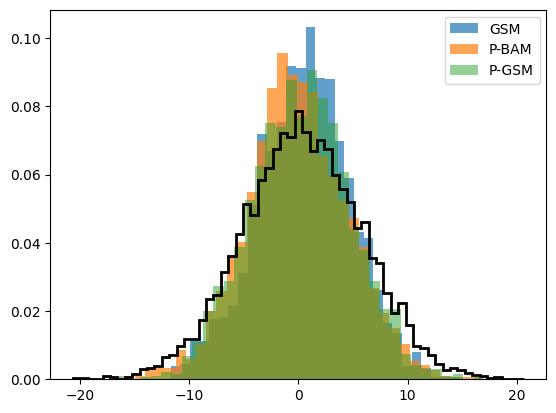

In [184]:
i = 0 

plt.hist(ref_samples[..., i], bins='auto', density=True, color='k', histtype='step', lw=2);
plt.hist(sgsm[..., i], bins='auto', density=True,alpha=0.7, label='GSM');
plt.hist(spbam[..., i], bins='auto', density=True,alpha=0.7, label='P-BAM');
plt.hist(spgsm[..., i], bins='auto', density=True,alpha=0.5, label='P-GSM');
plt.legend()

[]

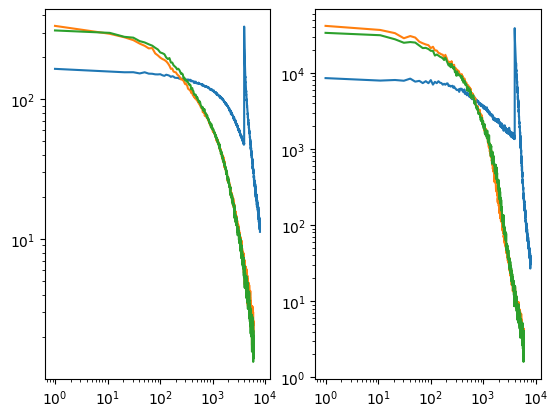

In [185]:
plt.subplot(121)
plt.plot(monitor.nevals, monitor.rkl)
plt.plot(monitor2.nevals, monitor2.rkl)
plt.plot(monitor3.nevals, monitor3.rkl)
plt.loglog()
plt.subplot(122)
plt.plot(monitor.nevals, monitor.fkl)
plt.plot(monitor2.nevals, monitor2.fkl)
plt.plot(monitor3.nevals, monitor3.fkl)
plt.loglog()
# plt.plot(monitor.rkl)

[ 92 395 307 296 276]


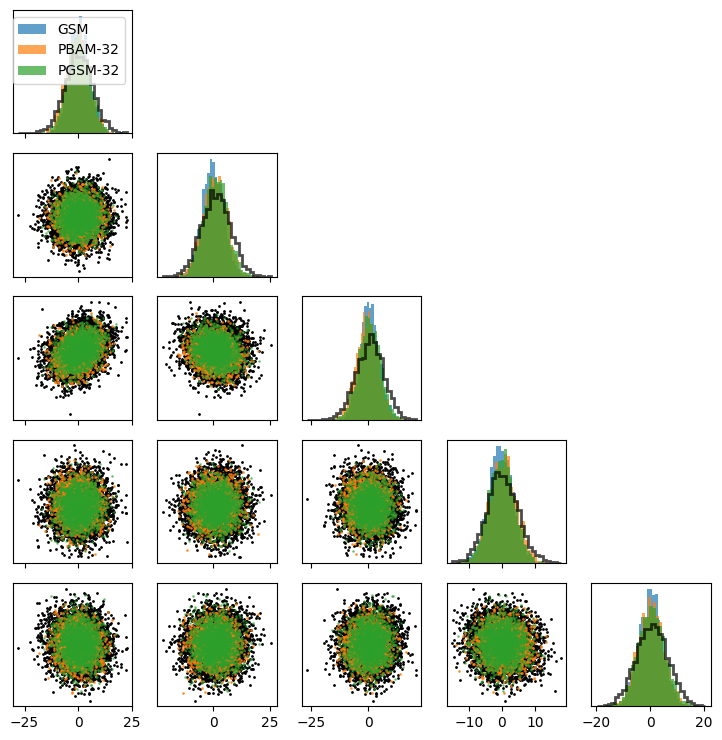

In [186]:
s = ref_samples[:5000, :] 

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(sgsm[..., ii], alpha=0.7, density=True, bins=30, label=f"GSM");
            ax[i, i].hist(spbam[..., ii], alpha=0.7, density=True, bins=30, label=f"PBAM-{ranklr}");
            ax[i, i].hist(spgsm[..., ii], alpha=0.7, density=True, bins=30, label=f"PGSM-{ranklr}");
            # if s2 is not None: ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}-fullcov");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            # ax[j, i].plot(sgsm[..., ii], sgsm[..., jj], '.', alpha=0.5, ms=2, color='C0')
            ax[j, i].plot(spbam[..., ii], spbam[..., jj], '.', alpha=0.7, ms=2, color='C1')
            ax[j, i].plot(spgsm[..., ii], spgsm[..., jj], '.', alpha=0.5, ms=2, color='C2')
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# image

In [75]:
from IPython.display import Image

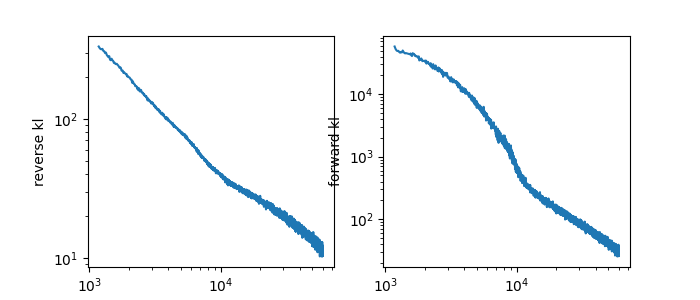

In [401]:
Image('../scripts/tmp/pgsm2048-loss.png')

# trucateed svd

In [88]:
from sklearn.decomposition import TruncatedSVD, 

In [154]:
algsvd = TruncatedSVD(n_components=k, n_iter=1000, n_oversamples=20)

In [149]:
m = llambda@llambda.T 

In [153]:
# res = algsvd.fit(llambda@llambda.T - llambda_update@llambda_update.T)
res = algsvd.fit(m)
m2 = (res.components_.T@res.components_ )#/(llambda@llambda.T )

In [181]:
u, e, v = np.linalg.svd(m, hermitian=True, full_matrices=False)

In [116]:
(res.components_.T@res.components_ ).shape

(32, 32)

In [398]:
def simultaneous_power_iteration(A, k, Q=None):
    np.random.seed(1)
    n, m = A.shape
    if Q is None: Q = np.random.rand(n, k)
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
    # print(A.shape, Q.shape)
 
    for i in range(100):
        Z = A@(Q)
        Q, R = np.linalg.qr(Z)
        # can use other stopping criteria as well 
        err = ((Q - Q_prev) ** 2).sum()
        if i % 10 == 0:
            pass
            # print(i, err)

        Q_prev = Q
        if err < 1e-3:
            break

    return np.diag(R), Q

def simultaneous_power_iteration2(u, v, k, Q=None):
    
    # n, m = A.shape
    np.random.seed(1)
    n = u.size   
    if Q is None: Q = np.random.rand(n, k)
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
    # print(A.shape, Q.shape)
    
    for i in range(10):
        Z = u@(u.T@(Q)) - v@(v.T@(Q))
        print(Z.shape)
        Q, R = np.linalg.qr(Z)
        # can use other stopping criteria as well 
        err = ((Q - Q_prev) ** 2).sum()
        if i % 10 == 0:
            pass
            # print(i, err)

        Q_prev = Q
        if err < 1e-3:
            break
    return np.diag(R), Q

d = 4096
A = np.random.random((d, d))
# simultaneous_power_iteration2(A[:, 0].reshape(-1, 1), 8)[1].shape

In [399]:
d = 8
# u, v = np.random.random((2, d, 1))*2#.astype(float32)
u, v = np.random.random((2, d, k))#.astype(float32)
print(u.shape)
A = u@u.T - v@v.T
k = 4
Q = np.random.rand(d, k)#.astype(float32)
# A.shape
# simultaneous_power_iteration(A, k, Q)[1], simultaneous_power_iteration(A, k, Q)[1], # simultaneous_power_iteration2(u, v, k, Q)[1]
# simultaneous_power_iteration(A, k, Q)[0]/simultaneous_power_iteration2(u, v, k, Q)[0]
m1 = simultaneous_power_iteration(A, k, Q)[1]
m2 = simultaneous_power_iteration2(u, v, k, Q)[1]

(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)


In [389]:
np.linalg.eig(m1@m1.T)[1]

array([[-9.89778621e-01,  1.42612348e-01,  9.49101708e-02,
        -4.41006635e-02,  8.52594882e-03, -3.42424413e-02,
         8.34082778e-04,  5.91939145e-02],
       [ 1.09741797e-01,  7.61645716e-01,  8.07894164e-01,
        -5.22808061e-01,  1.68174618e-01,  4.88178104e-01,
        -3.58224462e-02, -4.53070750e-01],
       [-1.95595186e-03, -1.35749769e-02,  3.51404504e-01,
        -7.77835996e-01, -9.86653397e-02, -4.90025104e-01,
        -2.83145349e-01,  4.02023440e-01],
       [-1.87633638e-02, -1.30224182e-01,  2.19093306e-01,
         1.17008183e-02, -2.89746302e-01, -1.02955211e-01,
        -2.06186037e-01,  4.13740751e-01],
       [ 3.39227283e-02,  2.35435372e-01,  1.84387964e-01,
         3.28491078e-01,  3.15710396e-01, -2.88456712e-01,
        -4.98461691e-01,  2.17572521e-01],
       [-1.60490942e-02, -1.11386219e-01,  5.16572457e-02,
         9.94310803e-02, -6.71549866e-01, -4.18864551e-02,
        -3.25216444e-01, -2.24954484e-01],
       [-3.44139468e-02, -2.388445

In [378]:
%timeit simultaneous_power_iteration(A[:, 0:1]@A[:, 0:1].T, 8)[1].shape

1.97 ms ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [379]:
# %timeit simultaneous_power_iteration2(A[:, 0].reshape(-1, 1), 8)[1].shape

TypeError: simultaneous_power_iteration2() missing 1 required positional argument: 'k'

In [362]:
A = u@u.T - v@v.T
Z = A@(Q)
np.random.seed(1)
Z = Z.astype(float32)
Q1, R = np.linalg.qr(Z)

Z2 = u@(u.T@(Q)) - v@(v.T@(Q)) 
Z2 = Z2.astype(float32)
np.random.seed(1)
Q21, R = np.linalg.qr(Z2)


In [363]:
Z/Z2

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)

In [364]:
Q1/ Q21

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)